In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
from pathlib import Path
import os
from nltk.tokenize import RegexpTokenizer
import nltk
# from sumy.summarizers.lex_rank import LexRankSummarizer 
# #Plain text parsers since we are parsing through text
# from sumy.parsers.plaintext import PlaintextParser
# #for tokenization
# from sumy.nlp.tokenizers import Tokenizer
from nltk.tokenize.toktok import ToktokTokenizer

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint


from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

from functions import *
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_colwidth", 200)
pd.set_option('display.expand_frame_repr', False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
os.chdir('/Users/ariadnavargas/Box Sync/i42 Projects/External Projects/Project ECHO/Phase 3. Execution and dissemination/')
textfile = Path("data/raw/NM COVID-19 Office Hours/")
graphs = Path("graphs/")
output = Path("outputs/")
models = Path("models/")
clean = Path("data/clean")
video1 = "2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_v2_speaker1.txt"
graph1 = video1.split('.txt')[0]
topic1_s1= video1.split('.txt')[0]+'_speaker_1.html'
topic1_s2= video1.split('.txt')[0]+'_speaker_2.html'
model1_s1 = video1.split('.txt')[0]+'_speaker1.pkl'
model1_s2 = video1.split('.txt')[0]+'_speaker2.pkl'
data1= video1.split('.txt')[0]+'.csv'

In [33]:
topic1_s1

'2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_v2_speaker1_speaker_1.html'

# Speaker 1

## Import text file

In [41]:
# Read text file into a dataframe
df = pd.read_csv(textfile/'2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_v2_speaker1.txt', sep="\t",
                 header=0,
                 names=["text", "minute"],
                 index_col=False)

In [42]:
df

,text,minute
0,"So it's going to be pretty, pretty, mostly clinical and epidemiological.",0.055167
1,"We have a lot of things to cover, but these are some of the main publication.",0.125500
2,"So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other...",0.189000
3,This publication by Moderna was was welcomed.,0.588500
4,They actually look at the data for patients 56 70 and also over 71.,0.653000
5,"And they were testing the two doses in their two protocols, the 25 microgram and a 100 microgram.",0.784500
6,And I can tell you right right off the bat that they're gonna use probably the old the higher dose for elderly patients.,0.885667
7,So the 100 microgram dose and we're going to show some of the results today.,1.023333
8,This is the basically the protocol.,1.106667
9,They have four groups.,1.162500


In [37]:
# Drop empty rows
df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

In [43]:
df.head()

,text,minute
0,"So it's going to be pretty, pretty, mostly clinical and epidemiological.",0.055167
1,"We have a lot of things to cover, but these are some of the main publication.",0.125500
2,"So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other...",0.189000
3,This publication by Moderna was was welcomed.,0.588500
4,They actually look at the data for patients 56 70 and also over 71.,0.653000


In [44]:
# displaying the number of rows and columns 
rows = df.shape[0] 
cols = df.shape[1] 
print("Rows: " + str(rows)) 
print("Columns: " + str(cols)) 

Rows: 106
Columns: 2


In [55]:
# convert dataframe to list
temp = df.values.tolist()

# for i in temp:
#     print(i[1])

In [56]:
# text=[]
# # remove inner brackets and quotes
# for t in temp:
#     nobrackets = str(t)[1:-1]
#     stripped = nobrackets.strip('"')
#     text.append(str(stripped)[1:-1])

In [65]:
text=[]
time=[]
for i in temp:
    text.append(i[0])
    time.append(i[1])    

In [67]:
# sanity check
for i in range(10):
    print(text[i] + ' Starting time: ' + str(time[i]))

So it's going to be pretty, pretty, mostly clinical and epidemiological. Starting time: 0.0551666666666666
We have a lot of things to cover, but these are some of the main publication. Starting time: 0.1255
So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other vaccines are usually not as effective in older groups, so it's important to take a look at how the new vaccines that we are developing against COVID-19 work in older folks. Starting time: 0.189
This publication by Moderna was was welcomed. Starting time: 0.5885
They actually look at the data for patients 56 70 and also over 71. Starting time: 0.653
And they were testing the two doses in their two protocols, the 25 microgram and a 100 microgram. Starting time: 0.7845
And I can tell you right right off the bat that they're gonna use probably the old the higher dose for elderly patients. Star

In [114]:
section=[]
for i in range(len(text)):
    section.append(0)
len(section)
x=0
for i in range(len(text)):
    if 'moderna' not in text[i].lower():
        section[i]=0
        x+=1
    elif 'moderna' in text[i].lower():
        section[i]=1
        x+=1
        print(x)
        break

for i in range(x,len(text)):
    if 'prophylaxis' not in text[i].lower():
        section[i]=1
        x+=1
    elif 'prophylaxis' in text[i].lower():
        section[i]=2
        x+=1
        print(x)
        break

for i in range(x,len(text)):
    if 'covid spreads' not in text[i].lower():
        section[i]=2
        x+=1
    elif 'covid spreads' in text[i].lower():
        section[i]=3
        x+=1
        print(x)
        break

for i in range(x,len(text)):
        section[i]=3

3
37
104


In [115]:
section

[0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3]

## Normalize and clean-up

### Build normalizer

In [18]:
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
import unicodedata
from bs4 import BeautifulSoup

nlp = spacy.load('en', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
# stopword_list.remove('no')
# stopword_list.remove('not')

# 1. Remove html tags
def strip_html_tags(text):
    soup=BeautifulSoup(text,"html.parser")
    stripped_text=soup.get_text()
    return stripped_text
strip_html_tags('<html><h2>Some important text</h2></html>')

# 2. Remove accents
def remove_accented_chars(text):    
    text=unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
remove_accented_chars('Sómê Áccèntéd téxt')

# 3. Expand contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
expand_contractions("Y'all can't expand contractions I'd think")

# 4. Remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, ' ', text)
    return text
remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

# 5. Lemmatization
def lemmatize_text(text):
    text=nlp(text)
    text=' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
lemmatize_text('My system keeps crashing! his crashed yesterday, ours crashes daily')

# 6. Stemming
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

# 7. Remove stopwords
def remove_stopwords(text, is_lowercase=False):
    tokens=tokenizer.tokenize(text)
    tokens=[token.strip() for token in tokens]
    if is_lowercase:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens=[token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
remove_stopwords("The, and, if are stopwords, computer is not")


', , stopwords , computer'

In [19]:
# Turn on functions as desired
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    # Run normalizer on corpus
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [20]:
df['text_clean'] = normalize_corpus(df['text'])
text_clean = list(df['text_clean'])

In [21]:
df.head(50)

,text,text_clean
0,"So it's going to be pretty, pretty, mostly clinical and epidemiological.",go pretty pretty mostly clinical epidemiological
1,"We have a lot of things to cover, but these are some of the main publication.",lot thing cover main publication
2,"So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...
3,This publication by Moderna was was welcomed.,publication moderna welcome
4,They actually look at the data for patients 56 and 70 and also over 71.,actually look datum patient also
5,"And they were testing the two doses in their two protocols, the 25 microgram and a 100 microgram.",test two dose two protocol microgram microgram
6,And I can tell you right right off the bat that they're gonna use probably the old the higher dose for elderly patients.,tell right right bat go use probably old high dose elderly patient
7,So the 100 microgram dose and we're going to show some of the results today.,microgram dose go show result today
8,This is the basically the protocol.,basically protocol
9,They have four groups.,four group


### Tokenize

In [22]:
from spacy.tokenizer import Tokenizer
tokens = []
tokenizer = Tokenizer(nlp.vocab)


for doc in tokenizer.pipe(df['text_clean'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         print(token)
        doc_tokens.append(token)
    tokens.append(doc_tokens)
# Makes tokens column
df['tokens']=tokens

df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

In [23]:
df.head()

,text,text_clean,tokens,tokens_back_to_text
0,"So it's going to be pretty, pretty, mostly clinical and epidemiological.",go pretty pretty mostly clinical epidemiological,"[go, pretty, pretty, mostly, clinical, epidemiological]",go pretty pretty mostly clinical epidemiological
1,"We have a lot of things to cover, but these are some of the main publication.",lot thing cover main publication,"[lot, thing, cover, main, publication]",lot thing cover main publication
2,"So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...,"[first, thing, datum, publish, new, england, journal, moderna, vaccine, old, patient, know, influenza, vaccine, influenza, vaccine, vaccine, usually, effective, old, group, important, take, look, ...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...
3,This publication by Moderna was was welcomed.,publication moderna welcome,"[publication, moderna, welcome]",publication moderna welcome
4,They actually look at the data for patients 56 and 70 and also over 71.,actually look datum patient also,"[actually, look, datum, patient, also]",actually look datum patient also


In [24]:
clean_text=df['tokens_back_to_text'].dropna()

big_string= ' '.join([text for text in clean_text])
    
words = big_string.split()
len(words)  

890

## Text mining

In [25]:
def get_trigrams(trigrams, top_grams):    
    grams_str = []
    data = []
    gram_counter = Counter(trigrams)
    for grams in gram_counter.most_common(20):
        gram = ''
        grams_str = grams[0]
        grams_str_count = []
        for n in range(0,3):
            gram = gram + grams_str[n] + ' '
        grams_str_count.append(gram)
        grams_str_count.append(grams[1])
        data.append(grams_str_count)
        print(grams_str_count)
    df = pd.DataFrame(data, columns = ['Grams', 'Count'])
    return df

def get_bigrams(bigrams, top_grams):    
    grams_str = []
    data = []

    gram_counter = Counter(bigrams)
    
    for grams in gram_counter.most_common(20):
        gram = ''
        grams_str = grams[0]
        grams_str_count = []
        for n in range(0,2):
            gram = gram + grams_str[n] + ' '
        grams_str_count.append(gram)
        grams_str_count.append(grams[1])
        data.append(grams_str_count)
        print(grams_str_count)
    df = pd.DataFrame(data, columns = ['Grams', 'Count'])
    return df


import seaborn as sns
def plot_frequency_chart(info):
#     sns.set_style("white")
    sns.set_style("ticks")
    sns.set_context("poster")
    sns.plotting_context()
    fig, ax = plt.subplots(figsize=(18, 8))
#     plt.style.use('seaborn-whitegrid')
    sns.set_context("notebook", font_scale=1)    
    ax = sns.barplot(x=info['x'], y=info['y'], data=info['data']
                     , color=(info['pal'])
                    )
    ax.yaxis.get_major_locator().set_params(integer=True)
    ax.set_title(label=info['title'], fontweight='bold', size=22)
    plt.ylabel(info['ylab'], fontsize=20)
    plt.xlabel(info['xlab'], fontsize=20)
    plt.xticks(rotation=info['angle'],fontsize=18)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(graphs/info['fname'])
    return

nlp = spacy.load('en_core_web_lg')
# Tokenizer
# tokenizer = Tokenizer(nlp.vocab)


['vaccine seem immunogenic ', 2]
['pre exposure prophylaxis ', 2]
['young age group ', 2]
['final report remdesivir ', 2]
['go go go ', 2]
['go pretty pretty ', 1]
['pretty pretty mostly ', 1]
['pretty mostly clinical ', 1]
['mostly clinical epidemiological ', 1]
['clinical epidemiological lot ', 1]
['epidemiological lot thing ', 1]
['lot thing cover ', 1]
['thing cover main ', 1]
['cover main publication ', 1]
['main publication first ', 1]
['publication first thing ', 1]
['first thing datum ', 1]
['thing datum publish ', 1]
['datum publish new ', 1]
['publish new england ', 1]


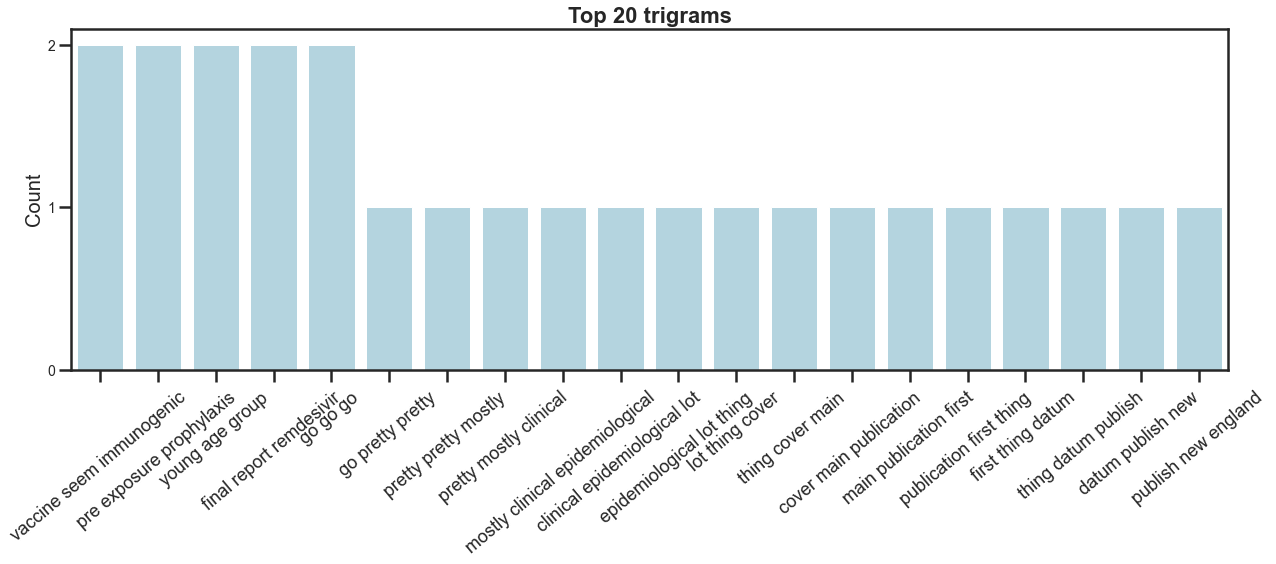

In [26]:
from collections import Counter
import matplotlib.pyplot as plt 

trigrams = nltk.trigrams(words)

df_trigrams = get_trigrams(trigrams, 10)

top25_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count',  'pal':'lightblue',
       'title': 'Top 20 trigrams',
       'fname': graph1+'trigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

['good news ', 5]
['high dose ', 4]
['final report ', 4]
['go go ', 4]
['neutralize antibody ', 3]
['age group ', 3]
['statistically significant ', 3]
['publication first ', 2]
['moderna vaccine ', 2]
['old patient ', 2]
['patient know ', 2]
['influenza vaccine ', 2]
['actually look ', 2]
['go use ', 2]
['adverse event ', 2]
['across board ', 2]
['immune response ', 2]
['dose mg ', 2]
['level antibody ', 2]
['antibody young ', 2]


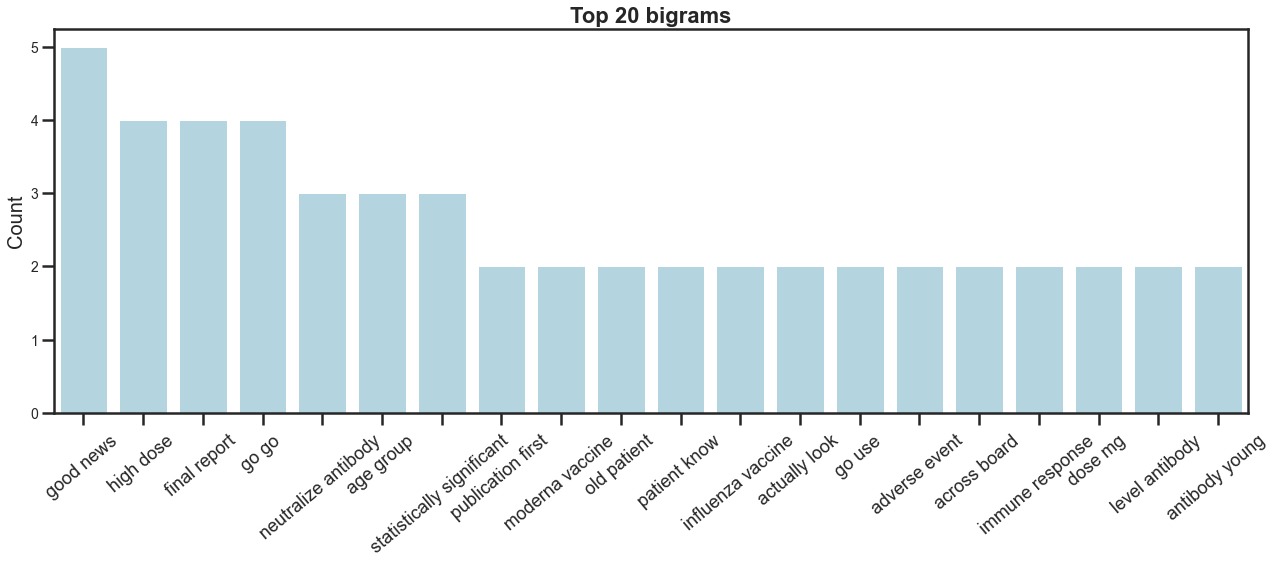

In [27]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_tri = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams',
       'fname': graph1+'bigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

In [28]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

unigrams = Counter(words).most_common(60)
unigrams
# # df_bigrams = get_bigrams(unigrams, 10)
# # top_tri = df_bigrams.iloc[:10,:]
# info = {'data': unigrams, 'x': 'Grams', 'y': 'Count',
#        'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
#        'title': 'Top 15 bigrams',
#        'fname': graph1+'.png',
#        'angle': 40}
# plot_frequency_chart(info)

[('patient', 22),
 ('see', 14),
 ('day', 14),
 ('know', 13),
 ('group', 13),
 ('covid', 12),
 ('go', 11),
 ('actually', 11),
 ('use', 11),
 ('high', 11),
 ('one', 11),
 ('vaccine', 10),
 ('dose', 10),
 ('symptom', 10),
 ('old', 8),
 ('also', 8),
 ('pretty', 7),
 ('publication', 7),
 ('result', 7),
 ('study', 7),
 ('young', 7),
 ('response', 7),
 ('age', 7),
 ('hydroxychloroquine', 7),
 ('report', 7),
 ('thing', 6),
 ('two', 6),
 ('trial', 6),
 ('think', 6),
 ('good', 6),
 ('antibody', 6),
 ('remdesivir', 6),
 ('important', 5),
 ('take', 5),
 ('basically', 5),
 ('early', 5),
 ('significant', 5),
 ('news', 5),
 ('still', 5),
 ('case', 5),
 ('like', 5),
 ('interesting', 5),
 ('final', 5),
 ('clinical', 4),
 ('first', 4),
 ('publish', 4),
 ('moderna', 4),
 ('look', 4),
 ('microgram', 4),
 ('right', 4),
 ('issue', 4),
 ('definitely', 4),
 ('level', 4),
 ('similar', 4),
 ('may', 4),
 ('severe', 4),
 ('another', 4),
 ('critical', 4),
 ('disease', 4),
 ('end', 4)]

In [29]:
df

,text,text_clean,tokens,tokens_back_to_text
0,"So it's going to be pretty, pretty, mostly clinical and epidemiological.",go pretty pretty mostly clinical epidemiological,"[go, pretty, pretty, mostly, clinical, epidemiological]",go pretty pretty mostly clinical epidemiological
1,"We have a lot of things to cover, but these are some of the main publication.",lot thing cover main publication,"[lot, thing, cover, main, publication]",lot thing cover main publication
2,"So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...,"[first, thing, datum, publish, new, england, journal, moderna, vaccine, old, patient, know, influenza, vaccine, influenza, vaccine, vaccine, usually, effective, old, group, important, take, look, ...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...
3,This publication by Moderna was was welcomed.,publication moderna welcome,"[publication, moderna, welcome]",publication moderna welcome
4,They actually look at the data for patients 56 and 70 and also over 71.,actually look datum patient also,"[actually, look, datum, patient, also]",actually look datum patient also
5,"And they were testing the two doses in their two protocols, the 25 microgram and a 100 microgram.",test two dose two protocol microgram microgram,"[test, two, dose, two, protocol, microgram, microgram]",test two dose two protocol microgram microgram
6,And I can tell you right right off the bat that they're gonna use probably the old the higher dose for elderly patients.,tell right right bat go use probably old high dose elderly patient,"[tell, right, right, bat, go, use, probably, old, high, dose, elderly, patient]",tell right right bat go use probably old high dose elderly patient
7,So the 100 microgram dose and we're going to show some of the results today.,microgram dose go show result today,"[microgram, dose, go, show, result, today]",microgram dose go show result today
8,This is the basically the protocol.,basically protocol,"[basically, protocol]",basically protocol
9,They have four groups.,four group,"[four, group]",four group


## Topic modeling

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 106 non-null    object
 1   text_clean           106 non-null    object
 2   tokens               106 non-null    object
 3   tokens_back_to_text  106 non-null    object
dtypes: object(4)
memory usage: 4.1+ KB


In [24]:
df.dropna(subset=['tokens_back_to_text'], inplace=True)

In [25]:
# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
#     tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['tokens2'] = df['tokens_back_to_text'].apply(tokenize)

In [26]:
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
newWord=['um', 'go', 'uh', 'yeah', 'also', 'much', 'okey', 
         'fantastic', 'oh', 'lot', 'thank', 'one', 'thing', 'say',
        'see', 'think', 'really', 'like', 'okay', 'th', 'know', 'actually', 'ah',
         'thank', 'n', 'yes', 'sort', 'whoa', 'r', 'mr', 'damn', 'mister']
for n in newWord:
    stopwords.append(n)

df['tokens2']=df['tokens2'].apply(lambda x: [item for item in x if item not in stopwords])

In [27]:
df=df[df['tokens2'].map(len) > 0]


In [28]:
df
id2word = Dictionary(df['tokens2'])
print(len(id2word))

377


In [29]:
df.dtypes

text                   object
text_clean             object
tokens                 object
tokens_back_to_text    object
tokens2                object
dtype: object

In [30]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

144


In [31]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['tokens2']]

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

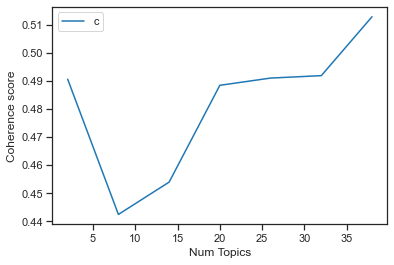

In [34]:
from gensim.models import LdaModel
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['tokens2'], start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig(graph1+'_coherence_speaker1.png')
plt.show()

In [35]:
# Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=4, id2word=id2word, workers=12, passes=50, iterations=50)

In [36]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics(num_topics=4)]

## Create and visualize the topics

In [37]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [38]:
base_model.show_topics(num_topics=4)
# base_model.show_topics(num_topics=25, num_words=10, log=False, formatted=True)

[(0,
  '0.058*"publication" + 0.037*"symptom" + 0.034*"critical" + 0.034*"high" + 0.028*"covid" + 0.026*"may" + 0.026*"day" + 0.025*"mortality" + 0.024*"interesting" + 0.024*"disease"'),
 (1,
  '0.077*"day" + 0.036*"two" + 0.036*"symptom" + 0.033*"dose" + 0.029*"right" + 0.022*"pretty" + 0.022*"definitely" + 0.022*"clinical" + 0.022*"microgram" + 0.022*"way"'),
 (2,
  '0.079*"patient" + 0.046*"vaccine" + 0.037*"old" + 0.036*"group" + 0.028*"report" + 0.027*"high" + 0.023*"take" + 0.023*"remdesivir" + 0.023*"covid" + 0.019*"another"'),
 (3,
  '0.040*"use" + 0.037*"age" + 0.032*"antibody" + 0.027*"group" + 0.027*"young" + 0.027*"still" + 0.024*"response" + 0.022*"study" + 0.022*"level" + 0.019*"dose"')]

In [39]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Subtopic {id} ------")
    print(t, end="\n\n")

------ Subtopic 0 ------
publication symptom critical high covid may day mortality interesting disease

------ Subtopic 1 ------
day two symptom dose right pretty definitely clinical microgram way

------ Subtopic 2 ------
patient vaccine old group report high take remdesivir covid another

------ Subtopic 3 ------
use age antibody group young still response study level dose



## Compute statistics to evaluate the model

In [40]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 


Perplexity:  -5.352908937207656


In [41]:
# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['tokens2'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Coherence Score:  0.4879307145403827


In [42]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.107093  0.077189       1        1  32.739745
3     -0.108893 -0.113647       2        1  29.159614
1      0.163544 -0.054192       3        1  20.238171
0      0.052442  0.090650       4        1  17.862470, topic_info=                   Term       Freq      Total Category  logprob  loglift
97                  day  11.000000  11.000000  Default  30.0000  30.0000
4           publication   6.000000   6.000000  Default  29.0000  29.0000
14              patient  18.000000  18.000000  Default  28.0000  28.0000
17              vaccine   8.000000   8.000000  Default  27.0000  27.0000
93              symptom   8.000000   8.000000  Default  26.0000  26.0000
59                  age   6.000000   6.000000  Default  25.0000  25.0000
13                  old   7.000000   7.000000  Default  24.0000  24.0000
90             critical   3.000000   3.000000  Default  23.0000  23.0000
21                  two   5.000000   5.000000  Default  22.0000  22.0000
50             antibody   5.000000   5.000000  Default  21.0000  21.0000
25                right   3.000000   3.000000  Default  20.0000  20.0000
26                  use   9.000000   9.000000  Default  19.0000  19.0000
23                 high   9.000000   9.000000  Default  18.0000  18.0000
9                 group  11.000000  11.000000  Default  17.0000  17.0000
66                still   4.000000   4.000000  Default  16.0000  16.0000
70                  may   3.000000   3.000000  Default  15.0000  15.0000
123           mortality   3.000000   3.000000  Default  14.0000  14.0000
39                  way   3.000000   3.000000  Default  13.0000  13.0000
69               almost   3.000000   3.000000  Default  12.0000  12.0000
18                 dose   8.000000   8.000000  Default  11.0000  11.0000
35                event   3.000000   3.000000  Default  10.0000  10.0000
96              disease   3.000000   3.000000  Default   9.0000   9.0000
110         interesting   4.000000   4.000000  Default   8.0000   8.0000
106              report   6.000000   6.000000  Default   7.0000   7.0000
16                 take   4.000000   4.000000  Default   6.0000   6.0000
40           definitely   3.000000   3.000000  Default   5.0000   5.0000
19            microgram   3.000000   3.000000  Default   4.0000   4.0000
0              clinical   3.000000   3.000000  Default   3.0000   3.0000
58                level   4.000000   4.000000  Default   2.0000   2.0000
98                  non   2.000000   2.000000  Default   1.0000   1.0000
17              vaccine   8.204657   8.793923   Topic1  -3.0886   1.0472
13                  old   6.602541   7.192930   Topic1  -3.3059   1.0309
16                 take   4.202215   4.791578   Topic1  -3.7577   0.9853
82              another   3.401856   3.991115   Topic1  -3.9690   0.9568
106              report   4.998986   6.354790   Topic1  -3.5841   0.8766
14              patient  14.166310  18.406677   Topic1  -2.5425   0.8547
8                  folk   1.800942   2.390178   Topic1  -4.6050   0.8335
125               large   1.800918   2.390177   Topic1  -4.6050   0.8335
62          immunogenic   1.800906   2.390177   Topic1  -4.6050   0.8335
128             require   1.800905   2.390177   Topic1  -4.6050   0.8335
84                 post   1.800896   2.390177   Topic1  -4.6051   0.8335
6                 datum   1.800836   2.390174   Topic1  -4.6051   0.8335
31               regard   1.800628   2.390165   Topic1  -4.6052   0.8334
43                board   1.799711   2.390119   Topic1  -4.6057   0.8329
42               across   1.799711   2.390119   Topic1  -4.6057   0.8329
118          remdesivir   4.178542   5.552902   Topic1  -3.7634   0.8322
119               graph   1.796494   2.390063   Topic1  -4.6075   0.8311
24             probably   1.793198   2.389933   Topic1  -4.6093   0.8293
117               final   3.401652   4.753596   Topic1  

In [43]:
p = pyLDAvis.gensim.prepare(base_model, corpus, id2word)
pyLDAvis.save_html(p, 'models/'+topic1_s1)

In [44]:
# save the model
import gzip
import pickle
with gzip.open(models/model1_s1, 'wb') as goodbye:
    pickle.dump(base_model, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
len(corpus)

104

In [46]:
# corpus from LDA model
corpus_transformed = base_model[corpus]

# confirm size
len(corpus_transformed)

104

In [47]:
# check out an example
corpus_transformed[0]

[(0, 0.0423277), (1, 0.87231165), (2, 0.043457743), (3, 0.04190288)]

In [48]:
%%time
# from gensim.models import LdaModel
# obtain the topic that a resembles the tweet most
topics = [lda_getter(x) for x in corpus_transformed]

# confirm shape
len(topics)

CPU times: user 19.3 ms, sys: 3.68 ms, total: 23 ms
Wall time: 19.9 ms


In [49]:
# turn list into dataframe column
df['topics'] = topics

# look at the first five rows
df.topics.head()

0    1
1    0
2    2
3    0
4    2
Name: topics, dtype: int64

In [50]:
df

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics
0,"So it's going to be pretty, pretty, mostly clinical and epidemiological.",go pretty pretty mostly clinical epidemiological,"[go, pretty, pretty, mostly, clinical, epidemiological]",go pretty pretty mostly clinical epidemiological,"[pretty, pretty, mostly, clinical, epidemiological]",1
1,"We have a lot of things to cover, but these are some of the main publication.",lot thing cover main publication,"[lot, thing, cover, main, publication]",lot thing cover main publication,"[cover, main, publication]",0
2,"So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...,"[first, thing, datum, publish, new, england, journal, moderna, vaccine, old, patient, know, influenza, vaccine, influenza, vaccine, vaccine, usually, effective, old, group, important, take, look, ...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...,"[first, datum, publish, new, england, journal, moderna, vaccine, old, patient, influenza, vaccine, influenza, vaccine, vaccine, usually, effective, old, group, important, take, look, new, vaccine,...",2
3,This publication by Moderna was was welcomed.,publication moderna welcome,"[publication, moderna, welcome]",publication moderna welcome,"[publication, moderna, welcome]",0
4,They actually look at the data for patients 56 and 70 and also over 71.,actually look datum patient also,"[actually, look, datum, patient, also]",actually look datum patient also,"[look, datum, patient]",2
5,"And they were testing the two doses in their two protocols, the 25 microgram and a 100 microgram.",test two dose two protocol microgram microgram,"[test, two, dose, two, protocol, microgram, microgram]",test two dose two protocol microgram microgram,"[test, two, dose, two, protocol, microgram, microgram]",1
6,And I can tell you right right off the bat that they're gonna use probably the old the higher dose for elderly patients.,tell right right bat go use probably old high dose elderly patient,"[tell, right, right, bat, go, use, probably, old, high, dose, elderly, patient]",tell right right bat go use probably old high dose elderly patient,"[tell, right, right, bat, use, probably, old, high, dose, elderly, patient]",2
7,So the 100 microgram dose and we're going to show some of the results today.,microgram dose go show result today,"[microgram, dose, go, show, result, today]",microgram dose go show result today,"[microgram, dose, show, result, today]",1
8,This is the basically the protocol.,basically protocol,"[basically, protocol]",basically protocol,"[basically, protocol]",3
9,They have four groups.,four group,"[four, group]",four group,"[four, group]",2


In [51]:
# convert lda tuples to dictionary
lda_topics_dict = [dict(x) for x in corpus_transformed]

# confirm
lda_topics_dict[0]

{0: 0.042327672, 1: 0.8723157, 2: 0.04345374, 3: 0.04190288}

In [52]:
# convert list of lda topic weights to dataframe
lda_df = pd.DataFrame(lda_topics_dict)

# rename columns
lda_df.rename(columns={i: f'lda_{i}' for i in range(10)}, inplace=True)

# replace NaNs with 0
lda_df.fillna(0, inplace=True)

# check it out
lda_df.head()

,lda_0,lda_1,lda_2,lda_3
0,0.042328,0.872316,0.043454,0.041903
1,0.624958,0.125017,0.125012,0.125013
2,0.012598,0.012559,0.962226,0.012617
3,0.741670,0.083384,0.091575,0.083372
4,0.063445,0.062530,0.811257,0.062768


In [53]:
df2 = pd.merge(df, lda_df, left_index=True, right_index=True)

In [54]:
df2.describe()

,topics,lda_0,lda_1,lda_2,lda_3
count,102.000000,102.000000,102.000000,102.000000,102.000000
mean,1.627451,0.192271,0.242000,0.299099,0.266629
std,1.089296,0.284122,0.319811,0.349056,0.337245
min,0.000000,0.012598,0.011110,0.011974,0.012617
25%,1.000000,0.035941,0.037569,0.042808,0.037219
50%,2.000000,0.062562,0.062725,0.083355,0.065285
75%,3.000000,0.126018,0.296379,0.673744,0.541339
max,3.000000,0.930486,0.915649,0.962226,0.940980


In [55]:
df2

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics,lda_0,lda_1,lda_2,lda_3
0,"So it's going to be pretty, pretty, mostly clinical and epidemiological.",go pretty pretty mostly clinical epidemiological,"[go, pretty, pretty, mostly, clinical, epidemiological]",go pretty pretty mostly clinical epidemiological,"[pretty, pretty, mostly, clinical, epidemiological]",1,0.042328,0.872316,0.043454,0.041903
1,"We have a lot of things to cover, but these are some of the main publication.",lot thing cover main publication,"[lot, thing, cover, main, publication]",lot thing cover main publication,"[cover, main, publication]",0,0.624958,0.125017,0.125012,0.125013
2,"So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...,"[first, thing, datum, publish, new, england, journal, moderna, vaccine, old, patient, know, influenza, vaccine, influenza, vaccine, vaccine, usually, effective, old, group, important, take, look, ...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...,"[first, datum, publish, new, england, journal, moderna, vaccine, old, patient, influenza, vaccine, influenza, vaccine, vaccine, usually, effective, old, group, important, take, look, new, vaccine,...",2,0.012598,0.012559,0.962226,0.012617
3,This publication by Moderna was was welcomed.,publication moderna welcome,"[publication, moderna, welcome]",publication moderna welcome,"[publication, moderna, welcome]",0,0.741670,0.083384,0.091575,0.083372
4,They actually look at the data for patients 56 and 70 and also over 71.,actually look datum patient also,"[actually, look, datum, patient, also]",actually look datum patient also,"[look, datum, patient]",2,0.063445,0.062530,0.811257,0.062768
5,"And they were testing the two doses in their two protocols, the 25 microgram and a 100 microgram.",test two dose two protocol microgram microgram,"[test, two, dose, two, protocol, microgram, microgram]",test two dose two protocol microgram microgram,"[test, two, dose, two, protocol, microgram, microgram]",1,0.035867,0.891939,0.035810,0.036384
6,And I can tell you right right off the bat that they're gonna use probably the old the higher dose for elderly patients.,tell right right bat go use probably old high dose elderly patient,"[tell, right, right, bat, go, use, probably, old, high, dose, elderly, patient]",tell right right bat go use probably old high dose elderly patient,"[tell, right, right, bat, use, probably, old, high, dose, elderly, patient]",2,0.025381,0.332337,0.616086,0.026196
7,So the 100 microgram dose and we're going to show some of the results today.,microgram dose go show result today,"[microgram, dose, go, show, result, today]",microgram dose go show result today,"[microgram, dose, show, result, today]",1,0.062523,0.809496,0.063462,0.064519
8,This is the basically the protocol.,basically protocol,"[basically, protocol]",basically protocol,"[basically, protocol]",3,0.084766,0.090372,0.083393,0.741468
9,They have four groups.,four group,"[four, group]",four group,"[four, group]",2,0.125036,0.125028,0.615541,0.134395


## Topic 0

In [58]:
# Topic 0
# (df.origin == "JFK") & (df.carrier == "B6")
df_filter = df2.loc[(df2.topics==0) & (df2.lda_0>0.7) ]

# df_filter = topics.loc[topic]

clean_text=df_filter['tokens_back_to_text'].dropna()

big_string= ' '.join([text for text in clean_text])

exceptions_list = [ 'go ', 'know ', 'also', 'column', 'left', 'lot'] # pull out these words from the corpus
for word in exceptions_list:
    big_string=big_string.replace(word,'')

big_string=remove_special_characters(big_string, 
                          remove_digits=False)
    
words = big_string.split()
len(words)   

52

['young age group ', 2]
['publication moderna welcome ', 1]
['moderna welcome fatigue ', 1]
['welcome fatigue people ', 1]
['fatigue people speculate ', 1]
['people speculate may ', 1]
['speculate may partly ', 1]
['may partly due ', 1]
['partly due critical ', 1]
['due critical face ', 1]
['critical face disease ', 1]
['face disease interesting ', 1]
['disease interesting finding ', 1]
['interesting finding trial ', 1]
['finding trial see ', 1]
['trial see factor ', 1]
['see factor associate ', 1]
['factor associate symptom ', 1]
['associate symptom persistence ', 1]
['symptom persistence find ', 1]


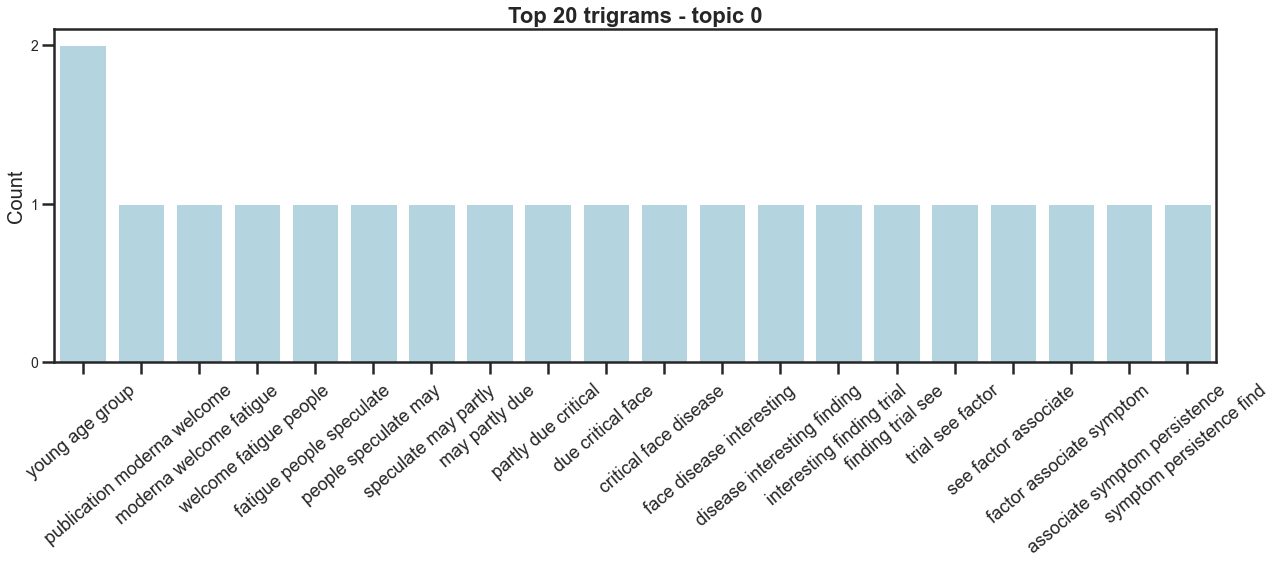

In [59]:
trigrams = nltk.trigrams(words)
df_trigrams = get_trigrams(trigrams, 10)
top_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 trigrams - topic 0',
       'fname':graph1+'_topic0_tigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

['young age ', 2]
['age group ', 2]
['publication moderna ', 1]
['moderna welcome ', 1]
['welcome fatigue ', 1]
['fatigue people ', 1]
['people speculate ', 1]
['speculate may ', 1]
['may partly ', 1]
['partly due ', 1]
['due critical ', 1]
['critical face ', 1]
['face disease ', 1]
['disease interesting ', 1]
['interesting finding ', 1]
['finding trial ', 1]
['trial see ', 1]
['see factor ', 1]
['factor associate ', 1]
['associate symptom ', 1]


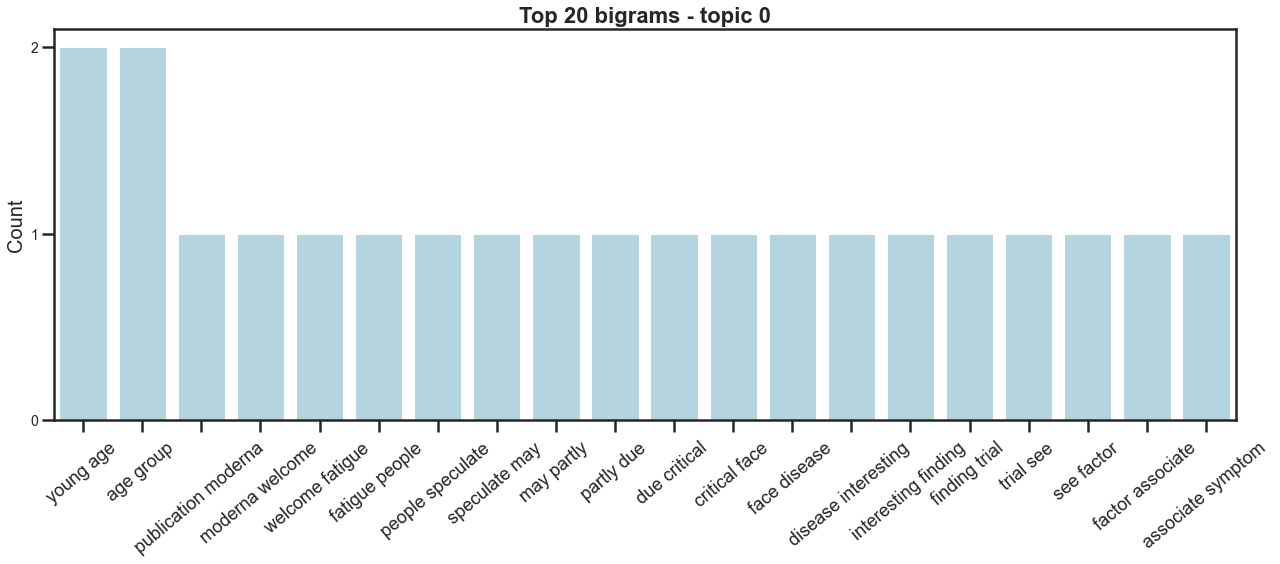

In [60]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_bi = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams - topic 0',
       'fname': graph1+'_topic0_bigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

In [61]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')
unigrams = Counter(words).most_common(20)
unigrams


[('publication', 4),
 ('disease', 2),
 ('interesting', 2),
 ('symptom', 2),
 ('young', 2),
 ('age', 2),
 ('group', 2),
 ('moderna', 1),
 ('welcome', 1),
 ('fatigue', 1),
 ('people', 1),
 ('speculate', 1),
 ('may', 1),
 ('partly', 1),
 ('due', 1),
 ('critical', 1),
 ('face', 1),
 ('finding', 1),
 ('trial', 1),
 ('see', 1)]

In [62]:
import random
tokens_topic = []

for doc in tokenizer.pipe(top_tri['Grams'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         if token.text.lower() not in STOP_WORDS:
        doc_tokens.append(token.text.lower())   
    tokens_topic.append(doc_tokens)
tokens_topic
tokens_topic_list=[]
for t in tokens_topic:
    if t[0] not in tokens_topic_list:
        tokens_topic_list.append(t[0])
    if t[1] not in tokens_topic_list:
        tokens_topic_list.append(t[1])
    if t[2] not in tokens_topic_list:
        tokens_topic_list.append(t[2])    
tokens_topic_list


tokens_list= '|'.join(tokens_topic_list)

tokens_list
contain_values = df_filter[df_filter['tokens_back_to_text'].str.contains(tokens_list)]
contain_values_list = contain_values['text'].tolist() 
len(contain_values_list)
random.seed(123)
# contain_values_sample=random.sample(contain_values,10)
for i in contain_values_list:
    print(i)
    print('--------------------------------------------------')

This publication by Moderna was was welcomed.
--------------------------------------------------
They have a lot of fatigue, and people have a speculated that that this may be partly just due to the, you know, the the critical face of the disease.
--------------------------------------------------
The other interesting finding on this trial was to to see if there were factors associated with symptoms persistence, and they found first the younger age group, a relatively younger age group 40 to 60 were more likely to have this symptoms if the patient was hospitalized, obviously, and if there were, there was evidence of a normal pulmonary auscultation, which are all markers or severe disease.
--------------------------------------------------
But we discussed that with the original publication and finally one a couple of epidemiological publication.
--------------------------------------------------
Interesting publication in and the MMWR.
-------------------------------------------------

In [63]:
contain_values

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics,lda_0,lda_1,lda_2,lda_3
3,This publication by Moderna was was welcomed.,publication moderna welcome,"[publication, moderna, welcome]",publication moderna welcome,"[publication, moderna, welcome]",0,0.741670,0.083384,0.091575,0.083372
49,"They have a lot of fatigue, and people have a speculated that that this may be partly just due to the, you know, the the critical face of the disease.",lot fatigue people speculate may partly due know critical face disease,"[lot, fatigue, people, speculate, may, partly, due, know, critical, face, disease]",lot fatigue people speculate may partly due know critical face disease,"[fatigue, people, speculate, may, partly, due, critical, face, disease]",0,0.899479,0.032542,0.036167,0.031811
63,"The other interesting finding on this trial was to to see if there were factors associated with symptoms persistence, and they found first the younger age group, a relatively younger age group 40 ...",interesting finding trial see factor associate symptom persistence find first young age group relatively young age group likely symptom patient hospitalize obviously evidence normal pulmonary ausc...,"[interesting, finding, trial, see, factor, associate, symptom, persistence, find, first, young, age, group, relatively, young, age, group, likely, symptom, patient, hospitalize, obviously, evidenc...",interesting finding trial see factor associate symptom persistence find first young age group relatively young age group likely symptom patient hospitalize obviously evidence normal pulmonary ausc...,"[interesting, finding, trial, factor, associate, symptom, persistence, find, first, young, age, group, relatively, young, age, group, likely, symptom, patient, hospitalize, obviously, evidence, no...",0,0.872039,0.042125,0.042778,0.043058
90,But we discussed that with the original publication and finally one a couple of epidemiological publication.,discuss original publication finally one couple epidemiological publication,"[discuss, original, publication, finally, one, couple, epidemiological, publication]",discuss original publication finally one couple epidemiological publication,"[discuss, original, publication, finally, couple, epidemiological, publication]",0,0.748798,0.083352,0.084426,0.083423
92,Interesting publication in and the MMWR.,interesting publication mmwr,"[interesting, publication, mmwr]",interesting publication mmwr,"[interesting, publication, mmwr]",0,0.809615,0.062540,0.062856,0.064989


## Topic 2

In [64]:
# Topic 2
df_filter = df2.loc[(df2.topics==2) & (df2.lda_2>0.7) ]

# df_filter = topics.loc[topic]

clean_text=df_filter['tokens_back_to_text'].dropna()

big_string= ' '.join([text for text in clean_text])

exceptions_list = [ 'go ', 'still', 'regard', 'think', 'somewhat', 'actually'] # pull out these words from the corpus
for word in exceptions_list:
    big_string=big_string.replace(word,'')

big_string=remove_special_characters(big_string, 
                          remove_digits=False)
    
words = big_string.split()
len(words)   

119

['first thing datum ', 1]
['thing datum publish ', 1]
['datum publish new ', 1]
['publish new england ', 1]
['new england journal ', 1]
['england journal moderna ', 1]
['journal moderna vaccine ', 1]
['moderna vaccine old ', 1]
['vaccine old patient ', 1]
['old patient know ', 1]
['patient know influenza ', 1]
['know influenza vaccine ', 1]
['influenza vaccine influenza ', 1]
['vaccine influenza vaccine ', 1]
['influenza vaccine vaccine ', 1]
['vaccine vaccine usually ', 1]
['vaccine usually effective ', 1]
['usually effective old ', 1]
['effective old group ', 1]
['old group important ', 1]


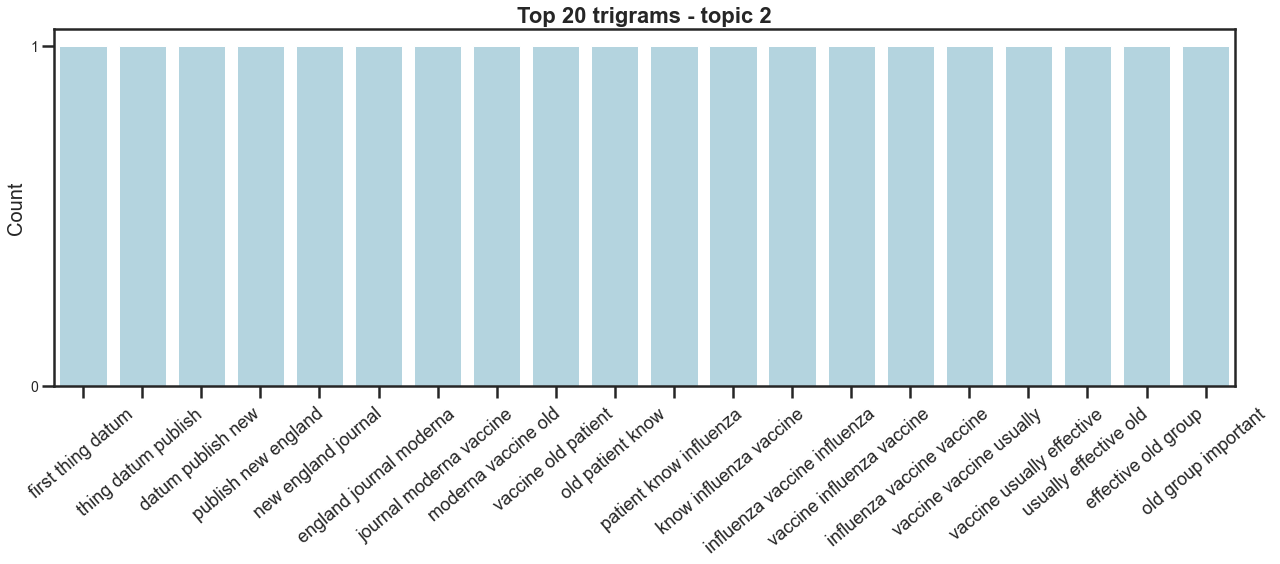

In [65]:
trigrams = nltk.trigrams(words)
df_trigrams = get_trigrams(trigrams, 10)
top_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 trigrams - topic 2',
       'fname':graph1+'_topic2_tigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

['influenza vaccine ', 2]
['take hydroxychloroquine ', 2]
['final report ', 2]
['first thing ', 1]
['thing datum ', 1]
['datum publish ', 1]
['publish new ', 1]
['new england ', 1]
['england journal ', 1]
['journal moderna ', 1]
['moderna vaccine ', 1]
['vaccine old ', 1]
['old patient ', 1]
['patient know ', 1]
['know influenza ', 1]
['vaccine influenza ', 1]
['vaccine vaccine ', 1]
['vaccine usually ', 1]
['usually effective ', 1]
['effective old ', 1]


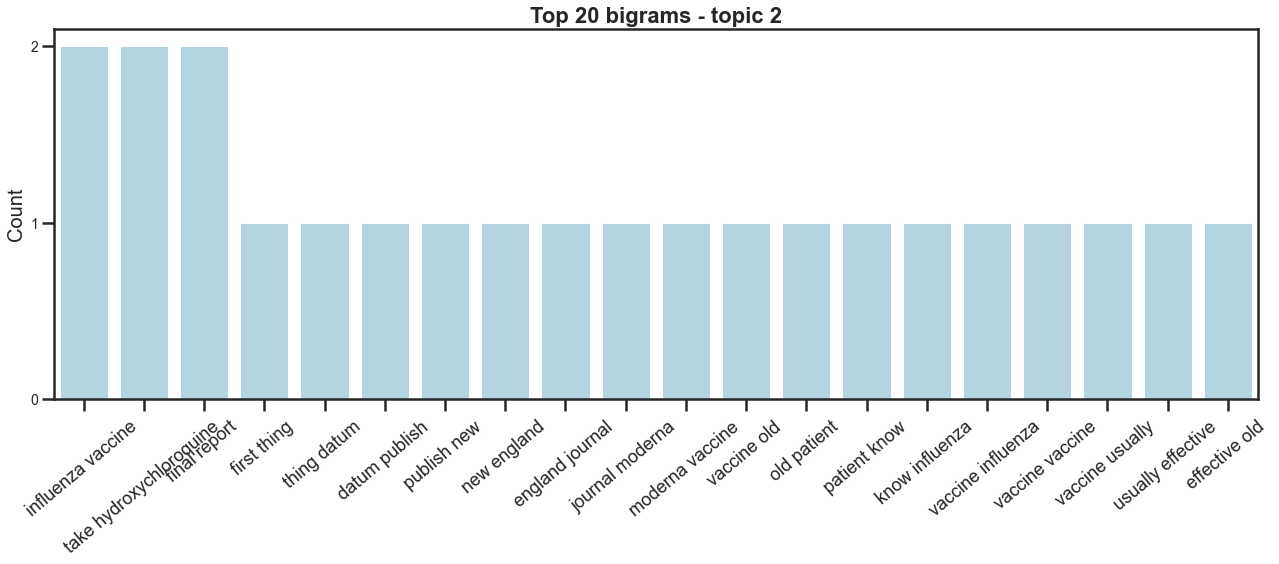

In [66]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_bi = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams - topic 2',
       'fname': graph1+'_topic2_bigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

In [67]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')
unigrams = Counter(words).most_common(20)
unigrams


[('vaccine', 8),
 ('patient', 5),
 ('take', 5),
 ('old', 4),
 ('group', 3),
 ('look', 3),
 ('report', 3),
 ('thing', 2),
 ('datum', 2),
 ('new', 2),
 ('know', 2),
 ('influenza', 2),
 ('covid', 2),
 ('mostly', 2),
 ('see', 2),
 ('significant', 2),
 ('hydroxychloroquine', 2),
 ('graph', 2),
 ('final', 2),
 ('first', 1)]

In [68]:
import random
tokens_topic = []

for doc in tokenizer.pipe(top_tri['Grams'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         if token.text.lower() not in STOP_WORDS:
        doc_tokens.append(token.text.lower())   
    tokens_topic.append(doc_tokens)
tokens_topic
tokens_topic_list=[]
for t in tokens_topic:
    if t[0] not in tokens_topic_list:
        tokens_topic_list.append(t[0])
    if t[1] not in tokens_topic_list:
        tokens_topic_list.append(t[1])
    if t[2] not in tokens_topic_list:
        tokens_topic_list.append(t[2])    
tokens_topic_list


tokens_list= '|'.join(tokens_topic_list)

tokens_list
contain_values = df_filter[df_filter['tokens_back_to_text'].str.contains(tokens_list)]
contain_values_list = contain_values['text'].tolist() 
len(contain_values_list)
random.seed(123)
# contain_values_sample=random.sample(contain_values,10)
for i in contain_values_list:
    print(i)
    print('--------------------------------------------------')

So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other vaccines are usually not as effective in older groups, so it's important to take a look at how the new vaccines that we are developing against COVID-19 work in older folks.
--------------------------------------------------
They actually look at the data for patients 56 and 70 and also over 71.
--------------------------------------------------
10 in each group, 10 patients in each group.
--------------------------------------------------
But mostly, mostly, were actually whites are not too many minorities represented in this study, which is an issue with some of these vaccine trials.
--------------------------------------------------
Janick and this is across the board, younger and older people.
--------------------------------------------------
And I think all of the vaccines that we have s

In [69]:
contain_values

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics,lda_0,lda_1,lda_2,lda_3
2,"So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...,"[first, thing, datum, publish, new, england, journal, moderna, vaccine, old, patient, know, influenza, vaccine, influenza, vaccine, vaccine, usually, effective, old, group, important, take, look, ...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...,"[first, datum, publish, new, england, journal, moderna, vaccine, old, patient, influenza, vaccine, influenza, vaccine, vaccine, usually, effective, old, group, important, take, look, new, vaccine,...",2,0.012598,0.012559,0.962226,0.012617
4,They actually look at the data for patients 56 and 70 and also over 71.,actually look datum patient also,"[actually, look, datum, patient, also]",actually look datum patient also,"[look, datum, patient]",2,0.063445,0.062530,0.811257,0.062768
10,"10 in each group, 10 patients in each group.",group patient group,"[group, patient, group]",group patient group,"[group, patient, group]",2,0.062694,0.062510,0.809669,0.065127
13,"But mostly, mostly, were actually whites are not too many minorities represented in this study, which is an issue with some of these vaccine trials.",mostly mostly actually white many minority represent study issue vaccine trial,"[mostly, mostly, actually, white, many, minority, represent, study, issue, vaccine, trial]",mostly mostly actually white many minority represent study issue vaccine trial,"[mostly, mostly, white, many, minority, represent, study, issue, vaccine, trial]",2,0.036876,0.037151,0.889098,0.036875
18,"Janick and this is across the board, younger and older people.",janick across board young old people,"[janick, across, board, young, old, people]",janick across board young old people,"[janick, across, board, young, old, people]",2,0.042706,0.041703,0.871895,0.043696
20,"And I think all of the vaccines that we have seen are associated with significant react allergenicity, which is bad for the patient.",think vaccine see associate significant react allergenicity bad patient,"[think, vaccine, see, associate, significant, react, allergenicity, bad, patient]",think vaccine see associate significant react allergenicity bad patient,"[vaccine, associate, significant, react, allergenicity, bad, patient]",2,0.054426,0.050370,0.844813,0.050391
21,"But it's good if you take it in into the if you interpret these as an immunological reaction to the vaccine, so it's not an inert material.",good take interpret immunological reaction vaccine inert material,"[good, take, interpret, immunological, reaction, vaccine, inert, material]",good take interpret immunological reaction vaccine inert material,"[good, take, interpret, immunological, reaction, vaccine, inert, material]",2,0.062524,0.062520,0.810758,0.064198
73,"And I'm gonna I'm not going to go over the you know, all over the graph and things that the result of this final report was very similar to the original bigger publication, the preliminary report.",go go go know graph thing result final report similar original big publication preliminary report,"[go, go, go, know, graph, thing, result, final, report, similar, original, big, publication, preliminary, report]",go go go know graph thing result final report similar original big publication preliminary report,"[graph, result, final, report, similar, original, big, publication, preliminary, report]",2,0.026958,0.130148,0.816959,0.025935
86,"So so the drug should be used presumably early, but in po

## Topic 1 

In [110]:
temp = df2.loc[(df2.topics==1)]
temp
df_filter = temp.loc[ (temp.lda_1>0.7) ]
df_filter
# df_filter = topics.loc[topic]

clean_text=df_filter['tokens_back_to_text'].dropna()

big_string= ' '.join([text for text in clean_text])

exceptions_list = [ 'go ', 'actually', 'also'] # pull out these words from the corpus
for word in exceptions_list:
    big_string=big_string.replace(word,'')

big_string=remove_special_characters(big_string, 
                          remove_digits=False)
    
words = big_string.split()
len(words)   

139

['pre exposure prophylaxis ', 2]
['pretty pretty mostly ', 1]
['pretty mostly clinical ', 1]
['mostly clinical epidemiological ', 1]
['clinical epidemiological first ', 1]
['epidemiological first thing ', 1]
['first thing datum ', 1]
['thing datum publish ', 1]
['datum publish new ', 1]
['publish new england ', 1]
['new england journal ', 1]
['england journal moderna ', 1]
['journal moderna vaccine ', 1]
['moderna vaccine old ', 1]
['vaccine old patient ', 1]
['old patient know ', 1]
['patient know influenza ', 1]
['know influenza vaccine ', 1]
['influenza vaccine influenza ', 1]
['vaccine influenza vaccine ', 1]


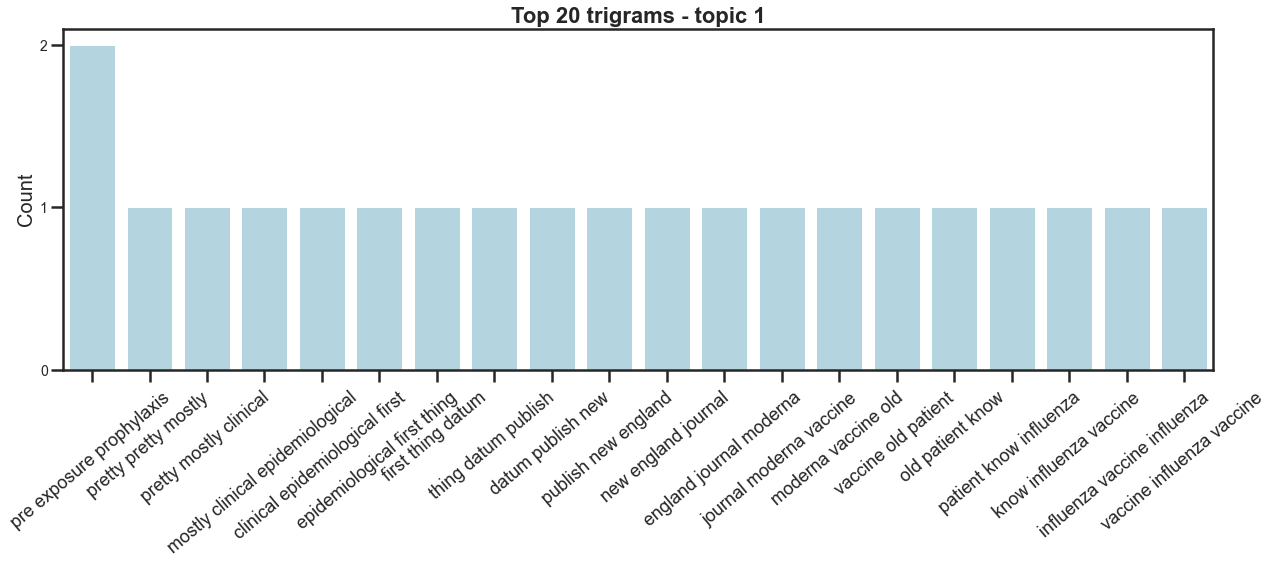

In [111]:
trigrams = nltk.trigrams(words)
df_trigrams = get_trigrams(trigrams, 10)
top_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 trigrams - topic 1',
       'fname':graph1+'_topic1_tigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

['patient know ', 2]
['influenza vaccine ', 2]
['immune response ', 2]
['pre exposure ', 2]
['exposure prophylaxis ', 2]
['study hydroxychloroquine ', 2]
['take hydroxychloroquine ', 2]
['pretty pretty ', 1]
['pretty mostly ', 1]
['mostly clinical ', 1]
['clinical epidemiological ', 1]
['epidemiological first ', 1]
['first thing ', 1]
['thing datum ', 1]
['datum publish ', 1]
['publish new ', 1]
['new england ', 1]
['england journal ', 1]
['journal moderna ', 1]
['moderna vaccine ', 1]


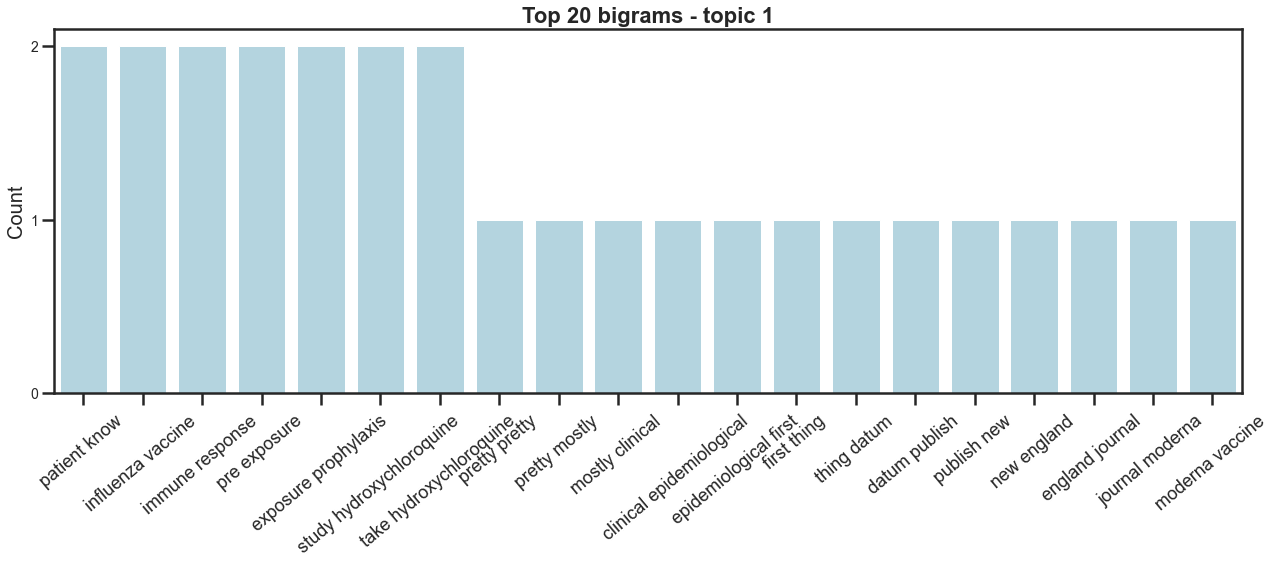

In [112]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_bi = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams - topic 1',
       'fname': graph1+'_topic1_bigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

In [113]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')
unigrams = Counter(words).most_common(20)
unigrams


[('vaccine', 6),
 ('hydroxychloroquine', 6),
 ('take', 5),
 ('covid', 4),
 ('pretty', 3),
 ('old', 3),
 ('patient', 3),
 ('know', 3),
 ('look', 3),
 ('prophylaxis', 3),
 ('datum', 2),
 ('new', 2),
 ('influenza', 2),
 ('important', 2),
 ('good', 2),
 ('fatigue', 2),
 ('area', 2),
 ('immune', 2),
 ('response', 2),
 ('pre', 2)]

In [114]:
import random
tokens_topic = []

for doc in tokenizer.pipe(top_tri['Grams'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         if token.text.lower() not in STOP_WORDS:
        doc_tokens.append(token.text.lower())   
    tokens_topic.append(doc_tokens)
tokens_topic
tokens_topic_list=[]
for t in tokens_topic:
    if t[0] not in tokens_topic_list:
        tokens_topic_list.append(t[0])
    if t[1] not in tokens_topic_list:
        tokens_topic_list.append(t[1])
    if t[2] not in tokens_topic_list:
        tokens_topic_list.append(t[2])    
tokens_topic_list


tokens_list= '|'.join(tokens_topic_list)

tokens_list
contain_values = df_filter[df_filter['tokens_back_to_text'].str.contains(tokens_list)]
contain_values_list = contain_values['text'].tolist() 
len(contain_values_list)
random.seed(123)
# contain_values_sample=random.sample(contain_values,10)
for i in contain_values_list:
    print(i)
    print('--------------------------------------------------')

So it's going to be pretty, pretty, mostly clinical and epidemiological.
--------------------------------------------------
So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other vaccines are usually not as effective in older groups, so it's important to take a look at how the new vaccines that we are developing against COVID-19 work in older folks.
--------------------------------------------------
They actually look at the data for patients 56 and 70 and also over 71.
--------------------------------------------------
And they were pretty balanced regarding gender and ethnicity.
--------------------------------------------------
But it's good if you take it in into the if you interpret these as an immunological reaction to the vaccine, so it's not an inert material.
--------------------------------------------------
It's actually something that

In [115]:
contain_values

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics,lda_0,lda_1,lda_2,lda_3
0,"So it's going to be pretty, pretty, mostly clinical and epidemiological.",go pretty pretty mostly clinical epidemiological,"[go, pretty, pretty, mostly, clinical, epidemiological]",go pretty pretty mostly clinical epidemiological,"[pretty, pretty, mostly, clinical, epidemiological]",1,0.043294,0.869468,0.043567,0.043671
2,"So the first thing was the data published in The New England Journal about the Moderna vaccine in older patients that, you know influenza and other vaccines are not as influenza vaccines and other...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...,"[first, thing, datum, publish, new, england, journal, moderna, vaccine, old, patient, know, influenza, vaccine, influenza, vaccine, vaccine, usually, effective, old, group, important, take, look, ...",first thing datum publish new england journal moderna vaccine old patient know influenza vaccine influenza vaccine vaccine usually effective old group important take look new vaccine develop covid...,"[first, datum, publish, new, england, journal, moderna, vaccine, old, patient, influenza, vaccine, influenza, vaccine, vaccine, usually, effective, old, group, important, take, look, new, vaccine,...",1,0.013100,0.960883,0.013243,0.012774
4,They actually look at the data for patients 56 and 70 and also over 71.,actually look datum patient also,"[actually, look, datum, patient, also]",actually look datum patient also,"[look, datum, patient]",1,0.062527,0.806898,0.067035,0.063540
12,And they were pretty balanced regarding gender and ethnicity.,pretty balanced regard gender ethnicity,"[pretty, balanced, regard, gender, ethnicity]",pretty balanced regard gender ethnicity,"[pretty, balanced, regard, gender, ethnicity]",1,0.088070,0.744616,0.083898,0.083416
21,"But it's good if you take it in into the if you interpret these as an immunological reaction to the vaccine, so it's not an inert material.",good take interpret immunological reaction vaccine inert material,"[good, take, interpret, immunological, reaction, vaccine, inert, material]",good take interpret immunological reaction vaccine inert material,"[good, take, interpret, immunological, reaction, vaccine, inert, material]",1,0.063278,0.809650,0.064550,0.062522
22,"It's actually something that you get some low grade fever, fatigue, soreness in the area of injection, but Hopefully, this will correlate with immune response and talking about immune response tha...",actually something get low grade fever fatigue soreness area injection hopefully correlate immune response talk immune response one important marker neutralize antibody,"[actually, something, get, low, grade, fever, fatigue, soreness, area, injection, hopefully, correlate, immune, response, talk, immune, response, one, important, marker, neutralize, antibody]",actually something get low grade fever fatigue soreness area injection hopefully correlate immune response talk immune response one important marker neutralize antibody,"[something, get, low, grade, fever, fatigue, soreness, area, injection, hopefully, correlate, immune, response, talk, immune, response, important, marker, neutralize, antibody]",1,0.022933,0.928087,0.023165,0.025815
36,I think the only the only area that is still somewhat debatable on hydroxychloroquine is we can use it as pre-exposure prophylaxis.,think area still somewhat debatable hydroxychloroquine use pre exposure prophylaxis,"[think, area, still, somewhat, debatable, hydroxychloroquine, use, pre, exposure, prophylaxis]",think area still somewhat debatable hydroxychloroquine use pre exposure prophylaxis,"[area, still, somewhat, debatable, hydroxychloroquine, use, pre, exposure, prophylaxis]",1,0.041850,0.873032,0.043419,0.041700
42,"It's another another negative study for for hydroxychloroquine, in t

## Topic 3

In [70]:
# Topic 3
df_filter = df2.loc[(df2.topics==3) & (df2.lda_3>0.7) ]

# df_filter = topics.loc[topic]

clean_text=df_filter['tokens_back_to_text'].dropna()

big_string= ' '.join([text for text in clean_text])

exceptions_list = [ 'go ', 'something', 'used', 'see', 'actually'] # pull out these words from the corpus
for word in exceptions_list:
    big_string=big_string.replace(word,'')

big_string=remove_special_characters(big_string, 
                          remove_digits=False)
    
words = big_string.split()
len(words)   

89

['basically protocol early ', 1]
['protocol early early ', 1]
['early early study ', 1]
['early study group ', 1]
['study group use ', 1]
['group use get ', 1]
['use get low ', 1]
['get low grade ', 1]
['low grade fever ', 1]
['grade fever fatigue ', 1]
['fever fatigue soreness ', 1]
['fatigue soreness area ', 1]
['soreness area injection ', 1]
['area injection hopefully ', 1]
['injection hopefully correlate ', 1]
['hopefully correlate immune ', 1]
['correlate immune response ', 1]
['immune response talk ', 1]
['response talk immune ', 1]
['talk immune response ', 1]


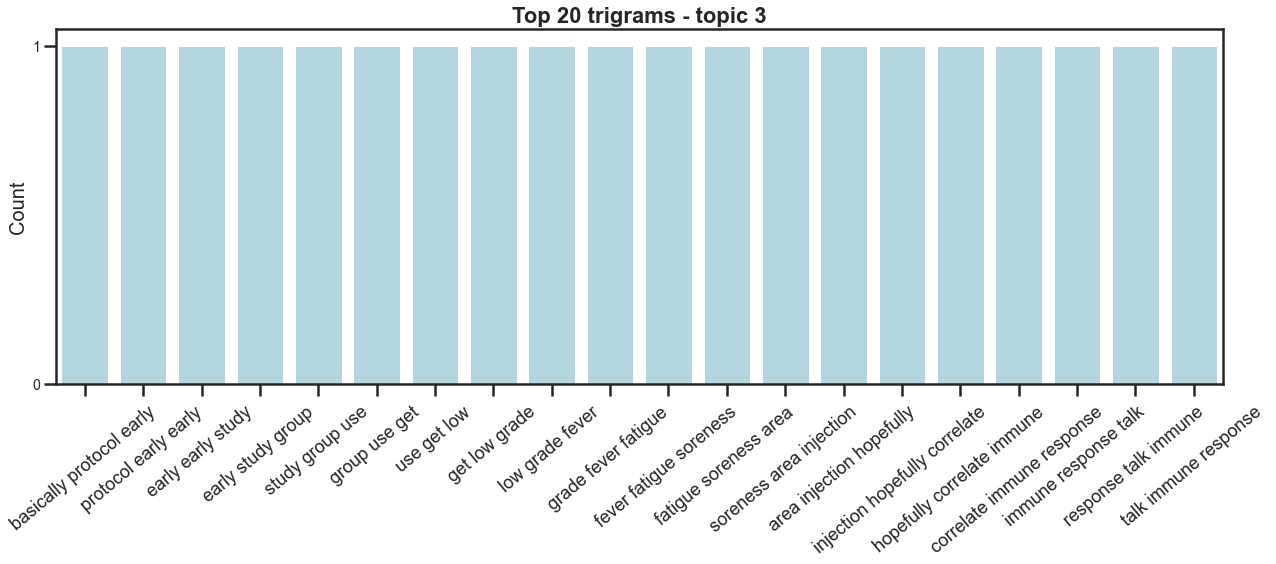

In [71]:
trigrams = nltk.trigrams(words)
df_trigrams = get_trigrams(trigrams, 10)
top_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 trigrams - topic 3',
       'fname':graph1+'_topic3_tigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

['immune response ', 2]
['neutralize antibody ', 2]
['dose mg ', 2]
['use mask ', 2]
['basically protocol ', 1]
['protocol early ', 1]
['early early ', 1]
['early study ', 1]
['study group ', 1]
['group use ', 1]
['use get ', 1]
['get low ', 1]
['low grade ', 1]
['grade fever ', 1]
['fever fatigue ', 1]
['fatigue soreness ', 1]
['soreness area ', 1]
['area injection ', 1]
['injection hopefully ', 1]
['hopefully correlate ', 1]


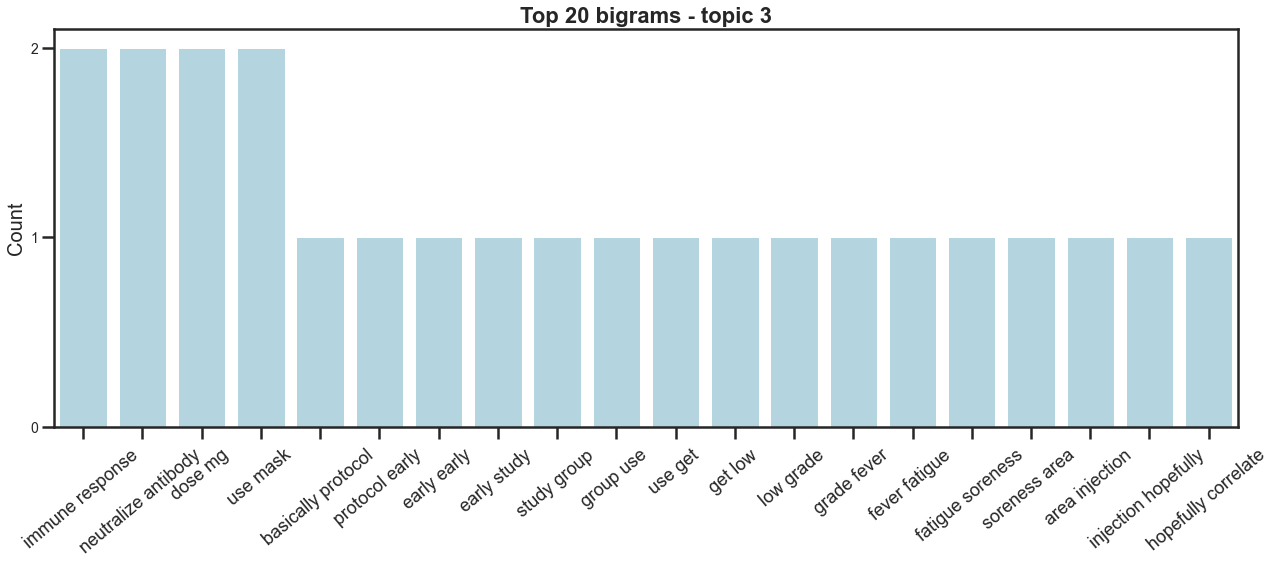

In [72]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_bi = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams - topic 3',
       'fname': graph1+'_topic3_bigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

In [73]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')
unigrams = Counter(words).most_common(20)
unigrams


[('use', 5),
 ('early', 3),
 ('antibody', 3),
 ('basically', 2),
 ('area', 2),
 ('immune', 2),
 ('response', 2),
 ('neutralize', 2),
 ('dose', 2),
 ('mg', 2),
 ('level', 2),
 ('think', 2),
 ('still', 2),
 ('hydroxychloroquine', 2),
 ('mask', 2),
 ('protocol', 1),
 ('study', 1),
 ('group', 1),
 ('get', 1),
 ('low', 1)]

In [74]:
import random
tokens_topic = []

for doc in tokenizer.pipe(top_tri['Grams'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         if token.text.lower() not in STOP_WORDS:
        doc_tokens.append(token.text.lower())   
    tokens_topic.append(doc_tokens)
tokens_topic
tokens_topic_list=[]
for t in tokens_topic:
    if t[0] not in tokens_topic_list:
        tokens_topic_list.append(t[0])
    if t[1] not in tokens_topic_list:
        tokens_topic_list.append(t[1])
    if t[2] not in tokens_topic_list:
        tokens_topic_list.append(t[2])    
tokens_topic_list


tokens_list= '|'.join(tokens_topic_list)

tokens_list
contain_values = df_filter[df_filter['tokens_back_to_text'].str.contains(tokens_list)]
contain_values_list = contain_values['text'].tolist() 
len(contain_values_list)
random.seed(123)
# contain_values_sample=random.sample(contain_values,10)
for i in contain_values_list:
    print(i)
    print('--------------------------------------------------')

This is the basically the protocol.
--------------------------------------------------
This is an early early study, 20 in that group of 56 to 70 and 20 in the more than than 71.
--------------------------------------------------
It's something that we're used to see.
--------------------------------------------------
It's actually something that you get some low grade fever, fatigue, soreness in the area of injection, but Hopefully, this will correlate with immune response and talking about immune response that one of the most important markers are the neutralizing antibodies.
--------------------------------------------------
We have the 2 25 doses in the 50 to 70 more than 71 the 100 mg, and you can see that the basically the levels of neutralizing antibody, especially the high dose the 100 mg, produces the same levels of antibody as younger patient.
--------------------------------------------------
I think the only the only area that is still somewhat debatable on hydroxychloroqui

In [75]:
contain_values

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics,lda_0,lda_1,lda_2,lda_3
8,This is the basically the protocol.,basically protocol,"[basically, protocol]",basically protocol,"[basically, protocol]",3,0.084766,0.090372,0.083393,0.741468
11,"This is an early early study, 20 in that group of 56 to 70 and 20 in the more than than 71.",early early study group,"[early, early, study, group]",early early study group,"[early, early, study, group]",3,0.050022,0.050018,0.052878,0.847082
15,It's something that we're used to see.,something use see,"[something, use, see]",something use see,"[something, use]",3,0.083365,0.083362,0.084456,0.748817
22,"It's actually something that you get some low grade fever, fatigue, soreness in the area of injection, but Hopefully, this will correlate with immune response and talking about immune response tha...",actually something get low grade fever fatigue soreness area injection hopefully correlate immune response talk immune response one important marker neutralize antibody,"[actually, something, get, low, grade, fever, fatigue, soreness, area, injection, hopefully, correlate, immune, response, talk, immune, response, one, important, marker, neutralize, antibody]",actually something get low grade fever fatigue soreness area injection hopefully correlate immune response talk immune response one important marker neutralize antibody,"[something, get, low, grade, fever, fatigue, soreness, area, injection, hopefully, correlate, immune, response, talk, immune, response, important, marker, neutralize, antibody]",3,0.023024,0.023193,0.023156,0.930628
24,"We have the 2 25 doses in the 50 to 70 more than 71 the 100 mg, and you can see that the basically the levels of neutralizing antibody, especially the high dose the 100 mg, produces the same level...",dose mg see basically level neutralize antibody especially high dose mg produce level antibody young patient,"[dose, mg, see, basically, level, neutralize, antibody, especially, high, dose, mg, produce, level, antibody, young, patient]",dose mg see basically level neutralize antibody especially high dose mg produce level antibody young patient,"[dose, mg, basically, level, neutralize, antibody, especially, high, dose, mg, produce, level, antibody, young, patient]",3,0.019400,0.019926,0.019694,0.940980
36,I think the only the only area that is still somewhat debatable on hydroxychloroquine is we can use it as pre-exposure prophylaxis.,think area still somewhat debatable hydroxychloroquine use pre exposure prophylaxis,"[think, area, still, somewhat, debatable, hydroxychloroquine, use, pre, exposure, prophylaxis]",think area still somewhat debatable hydroxychloroquine use pre exposure prophylaxis,"[area, still, somewhat, debatable, hydroxychloroquine, use, pre, exposure, prophylaxis]",3,0.043106,0.041888,0.042732,0.872274
38,"But there's still some some investigator, which think that if you use it early enough, you may have an effect.",still investigator think use early enough may effect,"[still, investigator, think, use, early, enough, may, effect]",still investigator think use early enough may effect,"[still, investigator, use, early, enough, may, effect]",3,0.063146,0.068630,0.064887,0.803337
96,But then they slowly started to implement measures.,slowly start implement measure,"[slowly, start, implement, measure]",slowly start implement measure,"[slowly, start, implement, measure]",3,0.032868,0.031272,0.031656,0.904203
98,They also mandated the use of mask and enforce the use of mask and you can see how dramatic the decrease in the number of cases occur at the end of the summer.,also mandate use mask enforce use mask see dramatic decrease number case occur end summer,"[also, mandate, use, mask, enforce, use, mask, see, dramatic, decrease, number, case, occur, end, summer]",also mandate use mask enforce use mask see dramatic decrease number case occur end summer,"[mandate, use, mask, enforce, use, mask, dramatic, decrease, number, case, occur, end, summer

# Speaker 2

## Import text file

In [94]:
video1 = "2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_speaker2.txt"

In [85]:
topic1_s2

'2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_speaker1_speaker_2.html'

In [95]:
# Read text file into a dataframe
df = pd.read_csv(textfile/video1, sep="\t",
                             header=0,
                             names=["text"])


In [96]:
# Drop empty rows
df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

In [97]:
df.head()

,text
0,It's from JAMA.
1,And it was on the science of persuasion.
2,"How you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention."
3,"So they talked about the five habit promoting strategies which, um, if you want somebody to develop a habit, get exercising or, um, eating more vegetables or wearing a mask."
4,They said there's five things to do.


In [98]:
# displaying the number of rows and columns 
rows = df.shape[0] 
cols = df.shape[1] 
print("Rows: " + str(rows)) 
print("Columns: " + str(cols)) 

Rows: 55
Columns: 1


In [99]:
# convert dataframe to list
temp = df.values.tolist()
temp

[["It's from JAMA."],
 ['And it was on the science of persuasion.'],
 ["How you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention."],
 ['So they talked about the five habit promoting strategies which, um, if you want somebody to develop a habit, get exercising or, um, eating more vegetables or wearing a mask.'],
 ["They said there's five things to do."],
 ['You want to make it easy to start and easy to repeat.'],
 ['You wanna make it rewarding to repeat, you want to tie the behavior to an existing habit.'],
 ['And I know I do this with people all the time suggesting they take pills when they first like that, and talk about behaviors that conflict with existing habits and provide alternative behaviors and provide specific descriptions of desire behaviors and they discussed for, um, the first one of making the behavior easy to start.'],
 ["Repeat, making handwashing stations and hand saniti

In [100]:
text=[]
# remove inner brackets and quotes
for t in temp:
    nobrackets = str(t)[1:-1]
    stripped = nobrackets.strip('"')
    text.append(str(stripped)[1:-1])

In [101]:
# sanity check
for i in range(10):
    print(text[i])

t's from JAMA
And it was on the science of persuasion.
ow you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention
So they talked about the five habit promoting strategies which, um, if you want somebody to develop a habit, get exercising or, um, eating more vegetables or wearing a mask.
hey said there's five things to do
You want to make it easy to start and easy to repeat.
You wanna make it rewarding to repeat, you want to tie the behavior to an existing habit.
And I know I do this with people all the time suggesting they take pills when they first like that, and talk about behaviors that conflict with existing habits and provide alternative behaviors and provide specific descriptions of desire behaviors and they discussed for, um, the first one of making the behavior easy to start.
epeat, making handwashing stations and hand sanitizer available everywhere really makes a difference on how 

## Normalize and clean-up

### Build normalizer

In [102]:
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
import unicodedata
from bs4 import BeautifulSoup

nlp = spacy.load('en', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
# stopword_list.remove('no')
# stopword_list.remove('not')

# 1. Remove html tags
def strip_html_tags(text):
    soup=BeautifulSoup(text,"html.parser")
    stripped_text=soup.get_text()
    return stripped_text
strip_html_tags('<html><h2>Some important text</h2></html>')

# 2. Remove accents
def remove_accented_chars(text):    
    text=unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
remove_accented_chars('Sómê Áccèntéd téxt')

# 3. Expand contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
expand_contractions("Y'all can't expand contractions I'd think")

# 4. Remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, ' ', text)
    return text
remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

# 5. Lemmatization
def lemmatize_text(text):
    text=nlp(text)
    text=' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
lemmatize_text('My system keeps crashing! his crashed yesterday, ours crashes daily')

# 6. Stemming
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

# 7. Remove stopwords
def remove_stopwords(text, is_lowercase=False):
    tokens=tokenizer.tokenize(text)
    tokens=[token.strip() for token in tokens]
    if is_lowercase:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens=[token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
remove_stopwords("The, and, if are stopwords, computer is not")


', , stopwords , computer'

In [103]:
# Turn on functions as desired
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    # Run normalizer on corpus
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [104]:
df['text_clean'] = normalize_corpus(df['text'])
text_clean = list(df['text_clean'])

In [105]:
df.head(50)

,text,text_clean
0,It's from JAMA.,jama
1,And it was on the science of persuasion.,science persuasion
2,"How you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention.",um guess actually lot study persuade people thing um opportune lesson covid prevention
3,"So they talked about the five habit promoting strategies which, um, if you want somebody to develop a habit, get exercising or, um, eating more vegetables or wearing a mask.",talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask
4,They said there's five things to do.,say five thing
5,You want to make it easy to start and easy to repeat.,want make easy start easy repeat
6,"You wanna make it rewarding to repeat, you want to tie the behavior to an existing habit.",wanna make rewarding repeat want tie behavior existing habit
7,"And I know I do this with people all the time suggesting they take pills when they first like that, and talk about behaviors that conflict with existing habits and provide alternative behaviors an...",know people time suggest take pill first like talk behavior conflict existing habit provide alternative behavior provide specific description desire behavior discuss um first one make behavior eas...
8,"Repeat, making handwashing stations and hand sanitizer available everywhere really makes a difference on how often people wash their hands, and you know it's obvious.",repeat make handwashing station hand sanitizer available everywhere really make difference often people wash hand know obvious
9,"But, um, often we don't have hand sanitizer readily available, so making it readily available.",um often hand sanitizer readily available make readily available


### Tokenize

In [106]:
from spacy.tokenizer import Tokenizer
tokens = []
tokenizer = Tokenizer(nlp.vocab)


for doc in tokenizer.pipe(df['text_clean'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         print(token)
        doc_tokens.append(token)
    tokens.append(doc_tokens)
# Makes tokens column
df['tokens']=tokens

df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

In [107]:
df.head()

,text,text_clean,tokens,tokens_back_to_text
0,It's from JAMA.,jama,[jama],jama
1,And it was on the science of persuasion.,science persuasion,"[science, persuasion]",science persuasion
2,"How you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention.",um guess actually lot study persuade people thing um opportune lesson covid prevention,"[um, guess, actually, lot, study, persuade, people, thing, um, opportune, lesson, covid, prevention]",um guess actually lot study persuade people thing um opportune lesson covid prevention
3,"So they talked about the five habit promoting strategies which, um, if you want somebody to develop a habit, get exercising or, um, eating more vegetables or wearing a mask.",talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask,"[talk, five, habit, promote, strategy, um, want, somebody, develop, habit, get, exercise, um, eat, vegetable, wear, mask]",talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask
4,They said there's five things to do.,say five thing,"[say, five, thing]",say five thing


In [108]:
clean_text=df['tokens_back_to_text'].dropna()

big_string= ' '.join([text for text in clean_text])
    
words = big_string.split()
len(words)  

561

## Text mining

In [109]:
def get_trigrams(trigrams, top_grams):    
    grams_str = []
    data = []
    gram_counter = Counter(trigrams)
    for grams in gram_counter.most_common(20):
        gram = ''
        grams_str = grams[0]
        grams_str_count = []
        for n in range(0,3):
            gram = gram + grams_str[n] + ' '
        grams_str_count.append(gram)
        grams_str_count.append(grams[1])
        data.append(grams_str_count)
        print(grams_str_count)
    df = pd.DataFrame(data, columns = ['Grams', 'Count'])
    return df

def get_bigrams(bigrams, top_grams):    
    grams_str = []
    data = []

    gram_counter = Counter(bigrams)
    
    for grams in gram_counter.most_common(20):
        gram = ''
        grams_str = grams[0]
        grams_str_count = []
        for n in range(0,2):
            gram = gram + grams_str[n] + ' '
        grams_str_count.append(gram)
        grams_str_count.append(grams[1])
        data.append(grams_str_count)
        print(grams_str_count)
    df = pd.DataFrame(data, columns = ['Grams', 'Count'])
    return df


import seaborn as sns
def plot_frequency_chart(info):
#     sns.set_style("white")
    sns.set_style("ticks")
    sns.set_context("poster")
    sns.plotting_context()
    fig, ax = plt.subplots(figsize=(18, 8))
#     plt.style.use('seaborn-whitegrid')
    sns.set_context("notebook", font_scale=1)    
    ax = sns.barplot(x=info['x'], y=info['y'], data=info['data']
                     , color=(info['pal'])
                    )
    ax.yaxis.get_major_locator().set_params(integer=True)
    ax.set_title(label=info['title'], fontweight='bold', size=22)
    plt.ylabel(info['ylab'], fontsize=20)
    plt.xlabel(info['xlab'], fontsize=20)
    plt.xticks(rotation=info['angle'],fontsize=18)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(graphs/info['fname'])
    return

nlp = spacy.load('en_core_web_lg')
# Tokenizer
# tokenizer = Tokenizer(nlp.vocab)


['lead cause death ', 4]
['child new york ', 4]
['third lead cause ', 3]
['clear consistent messaging ', 2]
['new york state ', 2]
['lose parent covid ', 2]
['jama science persuasion ', 1]
['science persuasion um ', 1]
['persuasion um guess ', 1]
['um guess actually ', 1]
['guess actually lot ', 1]
['actually lot study ', 1]
['lot study persuade ', 1]
['study persuade people ', 1]
['persuade people thing ', 1]
['people thing um ', 1]
['thing um opportune ', 1]
['um opportune lesson ', 1]
['opportune lesson covid ', 1]
['lesson covid prevention ', 1]


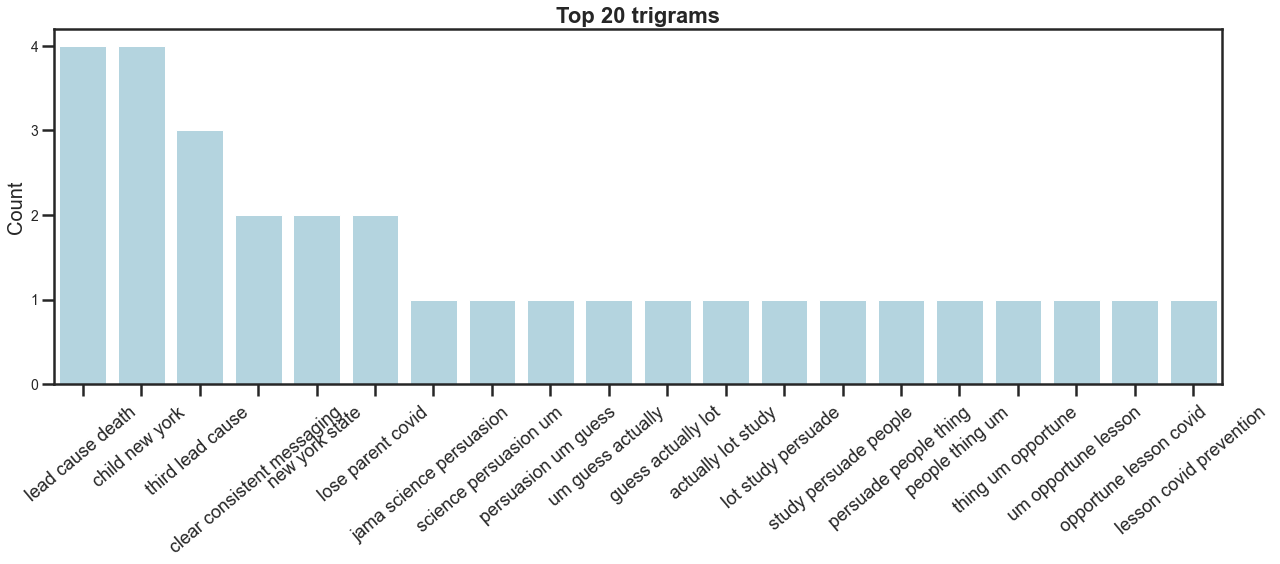

In [112]:
from collections import Counter
import matplotlib.pyplot as plt 

trigrams = nltk.trigrams(words)

df_trigrams = get_trigrams(trigrams, 10)

top25_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count',  'pal':'lightblue',
       'title': 'Top 20 trigrams',
       'fname': graph1+'trigrams_speaker2.png',
       'angle': 40}
plot_frequency_chart(info)

['new york ', 5]
['lead cause ', 4]
['cause death ', 4]
['child new ', 4]
['third lead ', 3]
['lose parent ', 3]
['think worth ', 3]
['wear mask ', 2]
['make easy ', 2]
['easy start ', 2]
['existing habit ', 2]
['hand sanitizer ', 2]
['readily available ', 2]
['clear consistent ', 2]
['consistent messaging ', 2]
['make people ', 2]
['um actually ', 2]
['back march ', 2]
['week covid ', 2]
['york state ', 2]


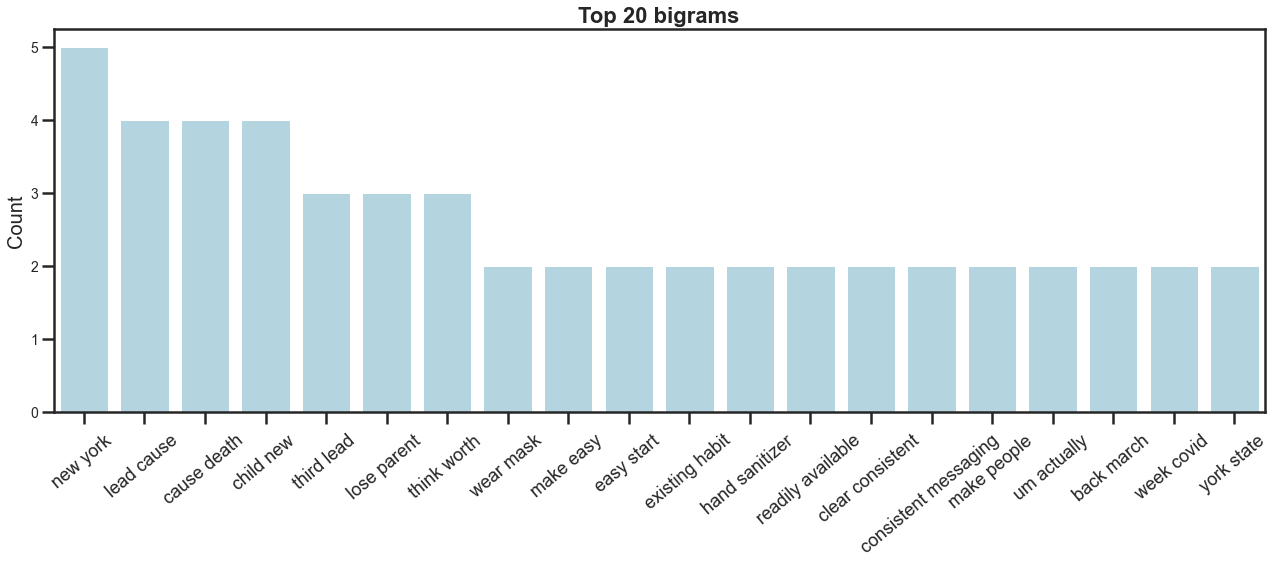

In [114]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_tri = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams',
       'fname': graph1+'bigrams_speaker2.png',
       'angle': 40}
plot_frequency_chart(info)

In [115]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

unigrams = Counter(words).most_common(60)
unigrams
# # df_bigrams = get_bigrams(unigrams, 10)
# # top_tri = df_bigrams.iloc[:10,:]
# info = {'data': unigrams, 'x': 'Grams', 'y': 'Count',
#        'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
#        'title': 'Top 15 bigrams',
#        'fname': graph1+'.png',
#        'angle': 40}
# plot_frequency_chart(info)

[('um', 20),
 ('people', 12),
 ('covid', 11),
 ('child', 11),
 ('make', 10),
 ('know', 10),
 ('one', 9),
 ('actually', 8),
 ('say', 8),
 ('really', 8),
 ('facebook', 7),
 ('talk', 6),
 ('want', 6),
 ('behavior', 6),
 ('think', 6),
 ('new', 6),
 ('easy', 5),
 ('good', 5),
 ('york', 5),
 ('poverty', 5),
 ('worth', 5),
 ('habit', 4),
 ('like', 4),
 ('also', 4),
 ('medical', 4),
 ('still', 4),
 ('lead', 4),
 ('cause', 4),
 ('death', 4),
 ('year', 4),
 ('lose', 4),
 ('parent', 4),
 ('article', 4),
 ('thing', 3),
 ('wear', 3),
 ('mask', 3),
 ('start', 3),
 ('repeat', 3),
 ('first', 3),
 ('hand', 3),
 ('available', 3),
 ('go', 3),
 ('public', 3),
 ('messaging', 3),
 ('state', 3),
 ('post', 3),
 ('march', 3),
 ('third', 3),
 ('th', 3),
 ('quite', 3),
 ('fairly', 3),
 ('lot', 2),
 ('lesson', 2),
 ('five', 2),
 ('get', 2),
 ('existing', 2),
 ('time', 2),
 ('provide', 2),
 ('discuss', 2),
 ('sanitizer', 2)]

## Topic modeling

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 55 non-null     object
 1   text_clean           55 non-null     object
 2   tokens               55 non-null     object
 3   tokens_back_to_text  55 non-null     object
dtypes: object(4)
memory usage: 2.1+ KB


In [117]:
df.dropna(subset=['tokens_back_to_text'], inplace=True)

In [118]:
# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
#     tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['tokens2'] = df['tokens_back_to_text'].apply(tokenize)

<input>:16: DeprecationWarning: invalid escape sequence \w
<input>:16: DeprecationWarning: invalid escape sequence \w
<input>:16: DeprecationWarning: invalid escape sequence \w
<input>:16: DeprecationWarning: invalid escape sequence \w
<input>:17: DeprecationWarning: invalid escape sequence \$
<input>:16: DeprecationWarning: invalid escape sequence \w
<input>:17: DeprecationWarning: invalid escape sequence \$
<input>:16: DeprecationWarning: invalid escape sequence \w
<input>:17: DeprecationWarning: invalid escape sequence \$
<input>:16: DeprecationWarning: invalid escape sequence \w
<input>:17: DeprecationWarning: invalid escape sequence \$
<input>:16: DeprecationWarning: invalid escape sequence \w
<input>:17: DeprecationWarning: invalid escape sequence \$
<input>:16: DeprecationWarning: invalid escape sequence \w
<input>:17: DeprecationWarning: invalid escape sequence \$
<input>:16: DeprecationWarning: invalid escape sequence \w
<input>:17: DeprecationWarning: invalid escape sequence 

In [119]:
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
newWord=['um', 'go', 'uh', 'yeah', 'also', 'much', 'okey', 
         'fantastic', 'oh', 'lot', 'thank', 'one', 'thing', 'say',
        'see', 'think', 'really', 'like', 'okay', 'th', 'know', 'actually', 'ah',
         'thank', 'n', 'yes', 'sort', 'whoa', 'r', 'mr', 'damn', 'mister']
for n in newWord:
    stopwords.append(n)

df['tokens2']=df['tokens2'].apply(lambda x: [item for item in x if item not in stopwords])

In [120]:
df=df[df['tokens2'].map(len) > 0]


In [121]:
df
id2word = Dictionary(df['tokens2'])
print(len(id2word))

275


In [122]:
df.dtypes

text                   object
text_clean             object
tokens                 object
tokens_back_to_text    object
tokens2                object
dtype: object

In [123]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

79


In [124]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['tokens2']]

In [125]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

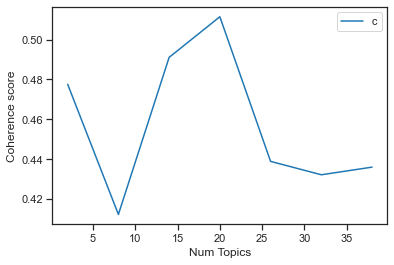

In [131]:
from gensim.models import LdaModel
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['tokens2'], start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig(graphs/'data1_coherence.png')
plt.show()

In [128]:
# Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=4, id2word=id2word, workers=12, passes=50, iterations=50)

In [132]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics(num_topics=4)]

## Create and visualize the topics

In [133]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [134]:
base_model.show_topics(num_topics=4)
# base_model.show_topics(num_topics=25, num_words=10, log=False, formatted=True)

[(0,
  '0.068*"facebook" + 0.047*"good" + 0.045*"worth" + 0.036*"quite" + 0.036*"cause" + 0.036*"lead" + 0.036*"death" + 0.036*"easy" + 0.035*"want" + 0.026*"make"'),
 (1,
  '0.138*"child" + 0.077*"new" + 0.064*"poverty" + 0.064*"york" + 0.052*"parent" + 0.052*"lose" + 0.042*"covid" + 0.040*"year" + 0.028*"find" + 0.028*"near"'),
 (2,
  '0.058*"make" + 0.057*"hand" + 0.057*"available" + 0.040*"article" + 0.039*"often" + 0.039*"sanitizer" + 0.039*"something" + 0.039*"grand" + 0.039*"round" + 0.039*"read"'),
 (3,
  '0.098*"people" + 0.061*"covid" + 0.054*"talk" + 0.054*"behavior" + 0.045*"make" + 0.037*"habit" + 0.029*"want" + 0.028*"wear" + 0.028*"mask" + 0.028*"public"')]

In [135]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Subtopic {id} ------")
    print(t, end="\n\n")

------ Subtopic 0 ------
facebook good worth quite cause lead death easy want make

------ Subtopic 1 ------
child new poverty york parent lose covid year find near

------ Subtopic 2 ------
make hand available article often sanitizer something grand round read

------ Subtopic 3 ------
people covid talk behavior make habit want wear mask public



## Compute statistics to evaluate the model

In [136]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 


Perplexity:  -4.718154473753746


In [137]:
# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['tokens2'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Coherence Score:  0.4486055775739068


In [138]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.070651 -0.167876       1        1  33.948019
0      0.096862  0.087678       2        1  26.345588
1     -0.224555  0.004286       3        1  24.193506
2      0.057043  0.075912       4        1  15.512888, topic_info=             Term       Freq      Total Category  logprob  loglift
52          child   9.000000   9.000000  Default  30.0000  30.0000
2          people  10.000000  10.000000  Default  29.0000  29.0000
53            new   5.000000   5.000000  Default  28.0000  28.0000
64        poverty   4.000000   4.000000  Default  27.0000  27.0000
54           york   4.000000   4.000000  Default  26.0000  26.0000
20           hand   2.000000   2.000000  Default  25.0000  25.0000
19      available   2.000000   2.000000  Default  24.0000  24.0000
40       facebook   6.000000   6.000000  Default  23.0000  23.0000
59         parent   3.000000   3.000000  Default  22.0000  22.0000
58           lose   3.000000   3.000000  Default  21.0000  21.0000
7            talk   5.000000   5.000000  Default  20.0000  20.0000
14       behavior   5.000000   5.000000  Default  19.0000  19.0000
11           make   8.000000   8.000000  Default  18.0000  18.0000
30           good   4.000000   4.000000  Default  17.0000  17.0000
72          worth   4.000000   4.000000  Default  16.0000  16.0000
69        article   3.000000   3.000000  Default  15.0000  15.0000
21          often   2.000000   2.000000  Default  14.0000  14.0000
22      sanitizer   2.000000   2.000000  Default  13.0000  13.0000
48      something   2.000000   2.000000  Default  12.0000  12.0000
75          round   2.000000   2.000000  Default  11.0000  11.0000
74          grand   2.000000   2.000000  Default  10.0000  10.0000
70           read   2.000000   2.000000  Default   9.0000   9.0000
51           year   3.000000   3.000000  Default   8.0000   8.0000
0           covid   9.000000   9.000000  Default   7.0000   7.0000
45          cause   3.000000   3.000000  Default   6.0000   6.0000
47           lead   3.000000   3.000000  Default   5.0000   5.0000
46          death   3.000000   3.000000  Default   4.0000   4.0000
56          quite   3.000000   3.000000  Default   3.0000   3.0000
5           habit   3.000000   3.000000  Default   2.0000   2.0000
49          third   3.000000   3.000000  Default   1.0000   1.0000
7            talk   4.902618   5.472087   Topic1  -2.9096   0.9704
14       behavior   4.899365   5.472088   Topic1  -2.9103   0.9698
2          people   8.824788  10.116301   Topic1  -2.3218   0.9438
5           habit   3.332972   3.903133   Topic1  -3.2955   0.9224
9            wear   2.549430   3.118680   Topic1  -3.5635   0.8788
6            mask   2.549379   3.118678   Topic1  -3.5635   0.8788
26         public   2.548748   3.118679   Topic1  -3.5638   0.8785
16        discuss   1.764846   2.334202   Topic1  -3.9313   0.8007
39           back   1.764842   2.334201   Topic1  -3.9313   0.8007
23          leave   1.764824   2.334201   Topic1  -3.9313   0.8007
1          lesson   1.764611   2.334190   Topic1  -3.9315   0.8006
68        similar   1.763812   2.334202   Topic1  -3.9319   0.8001
15       existing   1.762950   2.334164   Topic1  -3.9324   0.7997
73           myth   1.740607   2.333707   Topic1  -3.9452   0.7871
35         medium   1.728493   2.333717   Topic1  -3.9521   0.7801
0           covid   5.520223   9.336700   Topic1  -2.7910   0.5548
17          first   1.766595   3.103286   Topic1  -3.9303   0.5169
41          march   1.764153   3.103234   Topic1  -3.9317   0.5156
62         fairly   1.717166   3.120301   Topic1  -3.9587   0.4831
11           make   4.016448   8.386811   Topic1  -3.1090   0.3441
8            want   2.577495   5.426390   Topic1  -3.5526   0.3359
38        medical   1.762313   3.872256   Topic1  -3.9328   0.2931
43          still   1.761306   3.872231   Topic1  -3.9333   0.2926
66           la

In [76]:
p = pyLDAvis.gensim.prepare(base_model, corpus, id2word)
pyLDAvis.save_html(p, 'models/speaker1_'+topic1)

In [87]:
# save the model
import gzip
import pickle
with gzip.open(models/model1_s1, 'wb') as goodbye:
    pickle.dump(base_model, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

In [88]:
len(corpus)

104

In [326]:
# corpus from LDA model
corpus_transformed = base_model[corpus]

# confirm size
len(corpus_transformed)

55

In [327]:
# check out an example
corpus_transformed[0]

[(0, 0.25), (1, 0.25), (2, 0.25), (3, 0.25)]

In [328]:
%%time
# from gensim.models import LdaModel
# obtain the topic that a resembles the tweet most
topics = [lda_getter(x) for x in corpus_transformed]

# confirm shape
len(topics)

CPU times: user 9.25 ms, sys: 1.33 ms, total: 10.6 ms
Wall time: 9.29 ms


In [329]:
# turn list into dataframe column
df['topics'] = topics

# look at the first five rows
df.topics.head()

0    0
1    0
2    2
3    3
4    3
Name: topics, dtype: int64

In [330]:
df

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics
0,It's from JAMA.,jama,[jama],jama,[jama],0
1,And it was on the science of persuasion.,science persuasion,"[science, persuasion]",science persuasion,"[science, persuasion]",0
2,"How you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention.",um guess actually lot study persuade people thing um opportune lesson covid prevention,"[um, guess, actually, lot, study, persuade, people, thing, um, opportune, lesson, covid, prevention]",um guess actually lot study persuade people thing um opportune lesson covid prevention,"[guess, study, persuade, people, opportune, lesson, covid, prevention]",2
3,"So they talked about the five habit promoting strategies which, um, if you want somebody to develop a habit, get exercising or, um, eating more vegetables or wearing a mask.",talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask,"[talk, five, habit, promote, strategy, um, want, somebody, develop, habit, get, exercise, um, eat, vegetable, wear, mask]",talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask,"[talk, five, habit, promote, strategy, want, somebody, develop, habit, get, exercise, eat, vegetable, wear, mask]",3
4,They said there's five things to do.,say five thing,"[say, five, thing]",say five thing,[five],3
5,You want to make it easy to start and easy to repeat.,want make easy start easy repeat,"[want, make, easy, start, easy, repeat]",want make easy start easy repeat,"[want, make, easy, start, easy, repeat]",3
6,"You wanna make it rewarding to repeat, you want to tie the behavior to an existing habit.",wanna make rewarding repeat want tie behavior existing habit,"[wanna, make, rewarding, repeat, want, tie, behavior, existing, habit]",wanna make rewarding repeat want tie behavior existing habit,"[wanna, make, rewarding, repeat, want, tie, behavior, existing, habit]",3
7,"And I know I do this with people all the time suggesting they take pills when they first like that, and talk about behaviors that conflict with existing habits and provide alternative behaviors an...",know people time suggest take pill first like talk behavior conflict existing habit provide alternative behavior provide specific description desire behavior discuss um first one make behavior eas...,"[know, people, time, suggest, take, pill, first, like, talk, behavior, conflict, existing, habit, provide, alternative, behavior, provide, specific, description, desire, behavior, discuss, um, fir...",know people time suggest take pill first like talk behavior conflict existing habit provide alternative behavior provide specific description desire behavior discuss um first one make behavior eas...,"[people, time, suggest, take, pill, first, talk, behavior, conflict, existing, habit, provide, alternative, behavior, provide, specific, description, desire, behavior, discuss, first, make, behavi...",1
8,"Repeat, making handwashing stations and hand sanitizer available everywhere really makes a difference on how often people wash their hands, and you know it's obvious.",repeat make handwashing station hand sanitizer available everywhere really make difference often people wash hand know obvious,"[repeat, make, handwashing, station, hand, sanitizer, available, everywhere, really, make, difference, often, people, wash, hand, know, obvious]",repeat make handwashing station hand sanitizer available everywhere really make difference often people wash hand know obvious,"[repeat, make, handwashing, station, hand, sanitizer, available, everywhere, make, difference, often, people, wash, hand, obvious]",0
9,"But, um, often we don't have hand sanitizer readily available, so making it readily available.",um often hand sanitizer readily available make readily available,"[um, often, hand, sanitizer, readily, available, make, readily, availab

In [331]:
# convert lda tuples to dictionary
lda_topics_dict = [dict(x) for x in corpus_transformed]

# confirm
lda_topics_dict[0]

{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}

In [332]:
# convert list of lda topic weights to dataframe
lda_df = pd.DataFrame(lda_topics_dict)

# rename columns
lda_df.rename(columns={i: f'lda_{i}' for i in range(10)}, inplace=True)

# replace NaNs with 0
lda_df.fillna(0, inplace=True)

# check it out
lda_df.head()

,lda_0,lda_1,lda_2,lda_3
0,0.250000,0.250000,0.250000,0.250000
1,0.250000,0.250000,0.250000,0.250000
2,0.069025,0.068850,0.797107,0.065018
3,0.028512,0.030010,0.027791,0.913687
4,0.125117,0.125061,0.125052,0.624769


In [333]:
df2 = pd.merge(df, lda_df, left_index=True, right_index=True)

In [334]:
df2.describe()

,topics,lda_0,lda_1,lda_2,lda_3
count,55.000000,55.000000,55.000000,55.000000,55.000000
mean,1.545455,0.179643,0.252160,0.324413,0.243783
std,1.102492,0.263234,0.319601,0.339000,0.303733
min,0.000000,0.016343,0.020901,0.015704,0.016773
25%,1.000000,0.035752,0.038253,0.044428,0.038838
50%,2.000000,0.062588,0.083365,0.125033,0.083373
75%,2.000000,0.189975,0.250000,0.725615,0.334582
max,3.000000,0.924280,0.950874,0.937368,0.924286


In [335]:
df2

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics,lda_0,lda_1,lda_2,lda_3
0,It's from JAMA.,jama,[jama],jama,[jama],0,0.250000,0.250000,0.250000,0.250000
1,And it was on the science of persuasion.,science persuasion,"[science, persuasion]",science persuasion,"[science, persuasion]",0,0.250000,0.250000,0.250000,0.250000
2,"How you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention.",um guess actually lot study persuade people thing um opportune lesson covid prevention,"[um, guess, actually, lot, study, persuade, people, thing, um, opportune, lesson, covid, prevention]",um guess actually lot study persuade people thing um opportune lesson covid prevention,"[guess, study, persuade, people, opportune, lesson, covid, prevention]",2,0.069025,0.068850,0.797107,0.065018
3,"So they talked about the five habit promoting strategies which, um, if you want somebody to develop a habit, get exercising or, um, eating more vegetables or wearing a mask.",talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask,"[talk, five, habit, promote, strategy, um, want, somebody, develop, habit, get, exercise, um, eat, vegetable, wear, mask]",talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask,"[talk, five, habit, promote, strategy, want, somebody, develop, habit, get, exercise, eat, vegetable, wear, mask]",3,0.028512,0.030010,0.027791,0.913687
4,They said there's five things to do.,say five thing,"[say, five, thing]",say five thing,[five],3,0.125117,0.125061,0.125052,0.624769
5,You want to make it easy to start and easy to repeat.,want make easy start easy repeat,"[want, make, easy, start, easy, repeat]",want make easy start easy repeat,"[want, make, easy, start, easy, repeat]",3,0.038901,0.036961,0.035727,0.888411
6,"You wanna make it rewarding to repeat, you want to tie the behavior to an existing habit.",wanna make rewarding repeat want tie behavior existing habit,"[wanna, make, rewarding, repeat, want, tie, behavior, existing, habit]",wanna make rewarding repeat want tie behavior existing habit,"[wanna, make, rewarding, repeat, want, tie, behavior, existing, habit]",3,0.038286,0.037242,0.035729,0.888743
7,"And I know I do this with people all the time suggesting they take pills when they first like that, and talk about behaviors that conflict with existing habits and provide alternative behaviors an...",know people time suggest take pill first like talk behavior conflict existing habit provide alternative behavior provide specific description desire behavior discuss um first one make behavior eas...,"[know, people, time, suggest, take, pill, first, like, talk, behavior, conflict, existing, habit, provide, alternative, behavior, provide, specific, description, desire, behavior, discuss, um, fir...",know people time suggest take pill first like talk behavior conflict existing habit provide alternative behavior provide specific description desire behavior discuss um first one make behavior eas...,"[people, time, suggest, take, pill, first, talk, behavior, conflict, existing, habit, provide, alternative, behavior, provide, specific, description, desire, behavior, discuss, first, make, behavi...",1,0.016343,0.950874,0.015704,0.017080
8,"Repeat, making handwashing stations and hand sanitizer available everywhere really makes a difference on how often people wash their hands, and you know it's obvious.",repeat make handwashing station hand sanitizer available everywhere really make difference often people wash hand know obvious,"[repeat, make, handwashing, station, hand, sanitizer, available, everywhere, really, make, difference, often, people, wash, hand, know, obvious]",repeat make handwashing station hand sanitizer available everywhere really make difference often people wash hand know obvious,"[repeat, make, handwashing, station, hand, sanitizer, avai

## Topic 0

In [336]:
# Topic 0
# (df.origin == "JFK") & (df.carrier == "B6")
df_filter = df2.loc[(df2.topics==0) & (df2.lda_0>0.7) ]

# df_filter = topics.loc[topic]

clean_text=df_filter['tokens_back_to_text'].dropna()

big_string= ' '.join([text for text in clean_text])

exceptions_list = [ 'go ', 'know '] # pull out these words from the corpus
for word in exceptions_list:
    big_string=big_string.replace(word,'')

big_string=remove_special_characters(big_string, 
                          remove_digits=False)
    
words = big_string.split()
len(words)   

68

['child new york ', 2]
['lose parent covid ', 2]
['um guess actually ', 1]
['guess actually lot ', 1]
['actually lot study ', 1]
['lot study persuade ', 1]
['study persuade people ', 1]
['persuade people thing ', 1]
['people thing um ', 1]
['thing um opportune ', 1]
['um opportune lesson ', 1]
['opportune lesson covid ', 1]
['lesson covid prevention ', 1]
['covid prevention learn ', 1]
['prevention learn lesson ', 1]
['learn lesson one ', 1]
['lesson one actually ', 1]
['one actually really ', 1]
['actually really quite ', 1]
['really quite heartbreaking ', 1]


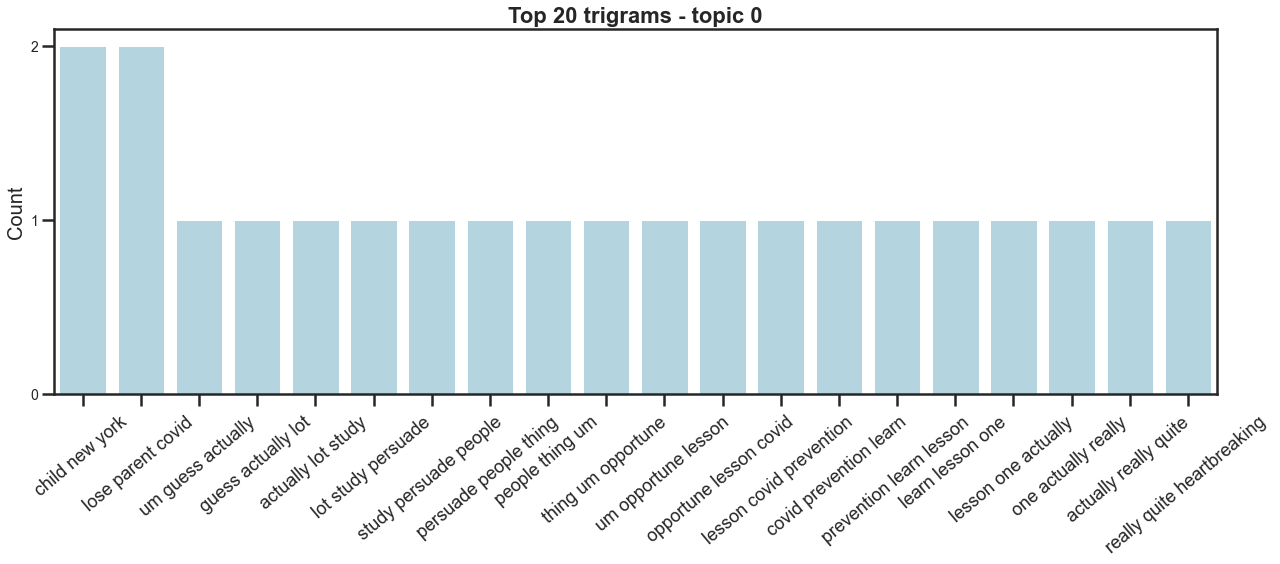

In [346]:
trigrams = nltk.trigrams(words)
df_trigrams = get_trigrams(trigrams, 10)
top_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 trigrams - topic 0',
       'fname':graph1+'_topic0_tigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

['lose parent ', 3]
['child new ', 2]
['new york ', 2]
['parent covid ', 2]
['child one ', 2]
['quite good ', 2]
['um guess ', 1]
['guess actually ', 1]
['actually lot ', 1]
['lot study ', 1]
['study persuade ', 1]
['persuade people ', 1]
['people thing ', 1]
['thing um ', 1]
['um opportune ', 1]
['opportune lesson ', 1]
['lesson covid ', 1]
['covid prevention ', 1]
['prevention learn ', 1]
['learn lesson ', 1]


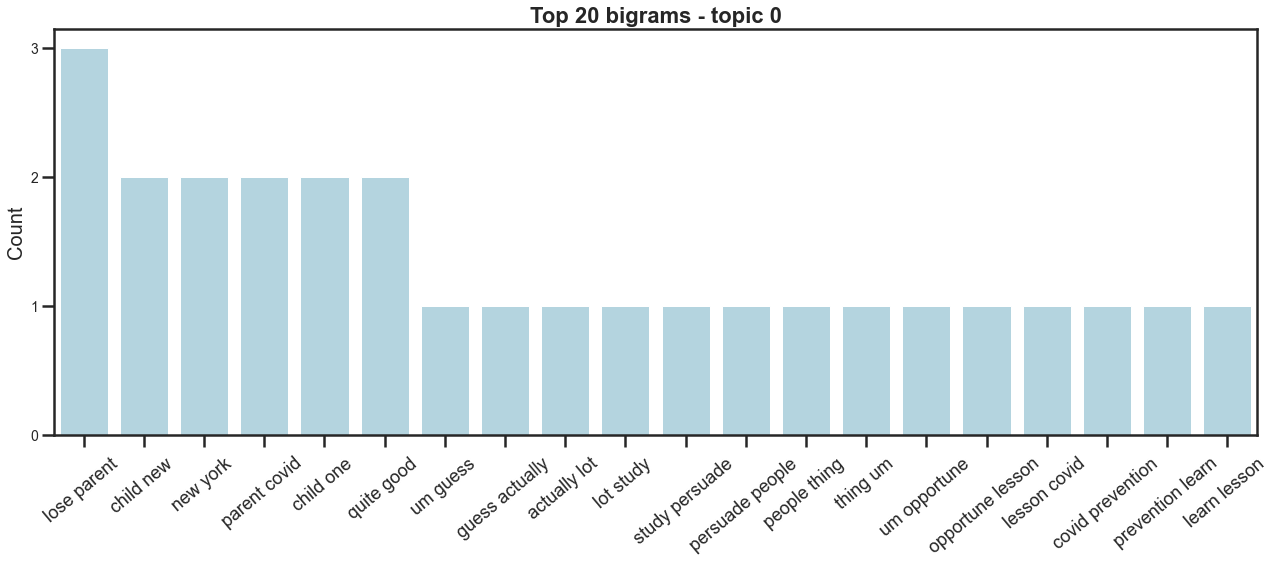

In [347]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_bi = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams - topic 0',
       'fname': graph1+'_topic0_bigrams_speaker1.png',
       'angle': 40}
plot_frequency_chart(info)

In [348]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')
unigrams = Counter(words).most_common(20)
unigrams


[('um', 9),
 ('covid', 9),
 ('child', 7),
 ('one', 6),
 ('parent', 4),
 ('really', 3),
 ('quite', 3),
 ('lose', 3),
 ('worth', 3),
 ('article', 3),
 ('actually', 2),
 ('people', 2),
 ('lesson', 2),
 ('heartbreaking', 2),
 ('new', 2),
 ('york', 2),
 ('hit', 2),
 ('fairly', 2),
 ('school', 2),
 ('also', 2)]

In [349]:
import random
tokens_topic = []

for doc in tokenizer.pipe(top_tri['Grams'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         if token.text.lower() not in STOP_WORDS:
        doc_tokens.append(token.text.lower())   
    tokens_topic.append(doc_tokens)
tokens_topic
tokens_topic_list=[]
for t in tokens_topic:
    if t[0] not in tokens_topic_list:
        tokens_topic_list.append(t[0])
    if t[1] not in tokens_topic_list:
        tokens_topic_list.append(t[1])
    if t[2] not in tokens_topic_list:
        tokens_topic_list.append(t[2])    
tokens_topic_list


tokens_list= '|'.join(tokens_topic_list)

tokens_list
contain_values = df_filter[df_filter['tokens_back_to_text'].str.contains(tokens_list)]
contain_values_list = contain_values['text'].tolist() 
len(contain_values_list)
random.seed(123)
# contain_values_sample=random.sample(contain_values,10)
for i in contain_values_list:
    print(i)
    print('--------------------------------------------------')

How you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention.
--------------------------------------------------
This one was actually really quite heartbreaking.
--------------------------------------------------
Um, the United Hospital Fund found that 4200 Children in New York had lost a parent to COVID-19 this year.
--------------------------------------------------
About 950 were Children of single parents and say, Well, they lost their only parent.
--------------------------------------------------
Um oh, it was one in 1000 Children in New York state lost a parent to COVID-19, um, one in 600 black Children, one in 700 Hispanic Children in one of 1500 white Children, Um, 57% were in Queens, Brooklyn or the Bronx, which were the hardest hit areas.
--------------------------------------------------
And those, of course, are the people who are the least able to absorb financial hit like tha

In [350]:
contain_values

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics,lda_0,lda_1,lda_2,lda_3
2,"How you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention.",um guess actually lot study persuade people thing um opportune lesson covid prevention,"[um, guess, actually, lot, study, persuade, people, thing, um, opportune, lesson, covid, prevention]",um guess actually lot study persuade people thing um opportune lesson covid prevention,"[guess, study, persuade, people, opportune, lesson, covid, prevention]",2,0.069025,0.068850,0.797107,0.065018
28,This one was actually really quite heartbreaking.,one actually really quite heartbreaking,"[one, actually, really, quite, heartbreaking]",one actually really quite heartbreaking,"[quite, heartbreaking]",2,0.083419,0.083378,0.749814,0.083389
29,"Um, the United Hospital Fund found that 4200 Children in New York had lost a parent to COVID-19 this year.",um united hospital fund find child new york lose parent covid year,"[um, united, hospital, fund, find, child, new, york, lose, parent, covid, year]",um united hospital fund find child new york lose parent covid year,"[united, hospital, fund, find, child, new, york, lose, parent, covid, year]",2,0.025018,0.025014,0.924620,0.025348
30,"About 950 were Children of single parents and say, Well, they lost their only parent.",child single parent say well lose parent,"[child, single, parent, say, well, lose, parent]",child single parent say well lose parent,"[child, single, parent, well, lose, parent]",2,0.050026,0.050014,0.849610,0.050351
31,"Um oh, it was one in 1000 Children in New York state lost a parent to COVID-19, um, one in 600 black Children, one in 700 Hispanic Children in one of 1500 white Children, Um, 57% were in Queens, B...",um oh one child new york state lose parent covid um one black child one hispanic child one white child um queen brooklyn bronx hard hit area,"[um, oh, one, child, new, york, state, lose, parent, covid, um, one, black, child, one, hispanic, child, one, white, child, um, queen, brooklyn, bronx, hard, hit, area]",um oh one child new york state lose parent covid um one black child one hispanic child one white child um queen brooklyn bronx hard hit area,"[child, new, york, state, lose, parent, covid, black, child, hispanic, child, white, child, queen, brooklyn, bronx, hard, hit, area]",2,0.020843,0.020901,0.937368,0.020888
36,"And those, of course, are the people who are the least able to absorb financial hit like that.",course people least able absorb financial hit like,"[course, people, least, able, absorb, financial, hit, like]",course people least able absorb financial hit like,"[course, people, least, able, absorb, financial, hit]",2,0.105298,0.102701,0.703003,0.088999
38,"This is fairly similar to the one I presented from Minnesota Department of Health last week, but there was a COVID-19 response toolkit it from the public elementary schools on how to deal with Chi...",fairly similar one present minnesota department health last week covid response toolkit public elementary school deal child symptomatic positive covid family exposure also update american academy ...,"[fairly, similar, one, present, minnesota, department, health, last, week, covid, response, toolkit, public, elementary, school, deal, child, symptomatic, positive, covid, family, exposure, also, ...",fairly similar one present minnesota department health last week covid response toolkit public elementary school deal child symptomatic positive covid family exposure also update american academy ...,"[fairly, similar, present, minnesota, department, health, last, week, covid, response, toolkit, public, elementary, school, deal, child, symptomatic, positive, covid, family, exposure, update, ame...",2,0.021127,0.021364,0.936659,0.020851
42,um COVID-19 myth busting by Robin.,um covid myth busting robin,"[um, covid, myth, busting, robin]",um covid myth busting robin,"[cov

## Topic 2

In [351]:
# Topic 2
df_filter = df2.loc[(df2.topics==2) & (df2.lda_2>0.7) ]

# df_filter = topics.loc[topic]

clean_text=df_filter['tokens_back_to_text'].dropna()

big_string= ' '.join([text for text in clean_text])

exceptions_list = [ 'go ', 'still', 'regard', 'think', 'somewhat'] # pull out these words from the corpus
for word in exceptions_list:
    big_string=big_string.replace(word,'')

big_string=remove_special_characters(big_string, 
                          remove_digits=False)
    
words = big_string.split()
len(words)   

169

['child new york ', 2]
['lose parent covid ', 2]
['um guess actually ', 1]
['guess actually lot ', 1]
['actually lot study ', 1]
['lot study persuade ', 1]
['study persuade people ', 1]
['persuade people thing ', 1]
['people thing um ', 1]
['thing um opportune ', 1]
['um opportune lesson ', 1]
['opportune lesson covid ', 1]
['lesson covid prevention ', 1]
['covid prevention learn ', 1]
['prevention learn lesson ', 1]
['learn lesson one ', 1]
['lesson one actually ', 1]
['one actually really ', 1]
['actually really quite ', 1]
['really quite heartbreaking ', 1]


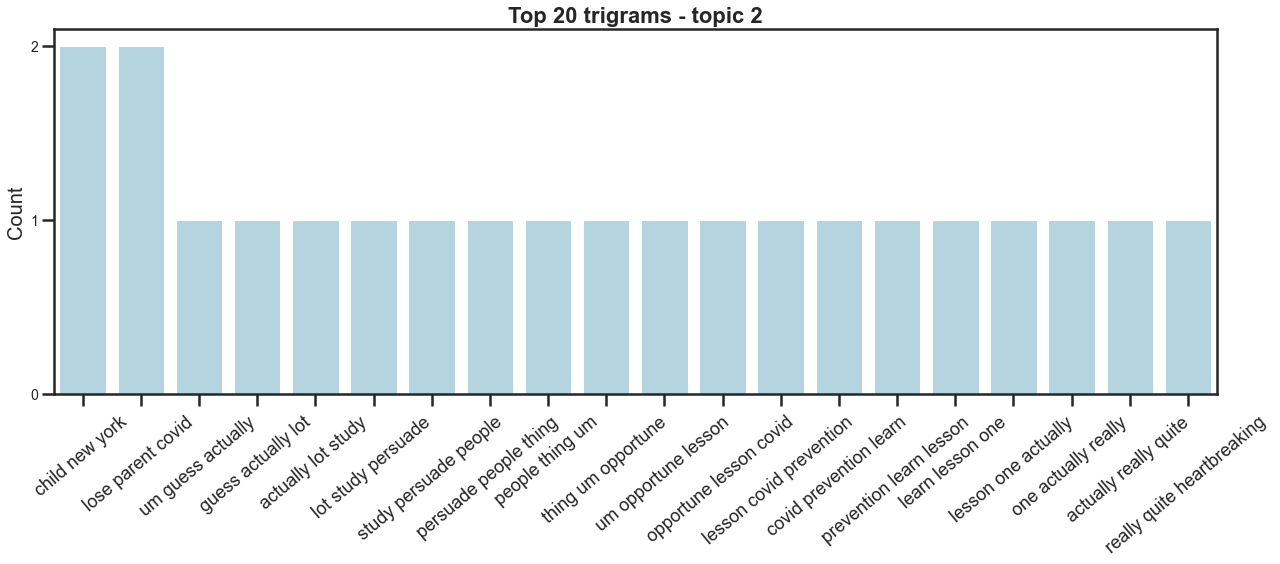

In [352]:
trigrams = nltk.trigrams(words)
df_trigrams = get_trigrams(trigrams, 10)
top_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 trigrams - topic 2',
       'fname':graph1+'_topic2_tigrams_speaker2.png',
       'angle': 40}
plot_frequency_chart(info)

['lose parent ', 3]
['child new ', 2]
['new york ', 2]
['parent covid ', 2]
['child one ', 2]
['quite good ', 2]
['um guess ', 1]
['guess actually ', 1]
['actually lot ', 1]
['lot study ', 1]
['study persuade ', 1]
['persuade people ', 1]
['people thing ', 1]
['thing um ', 1]
['um opportune ', 1]
['opportune lesson ', 1]
['lesson covid ', 1]
['covid prevention ', 1]
['prevention learn ', 1]
['learn lesson ', 1]


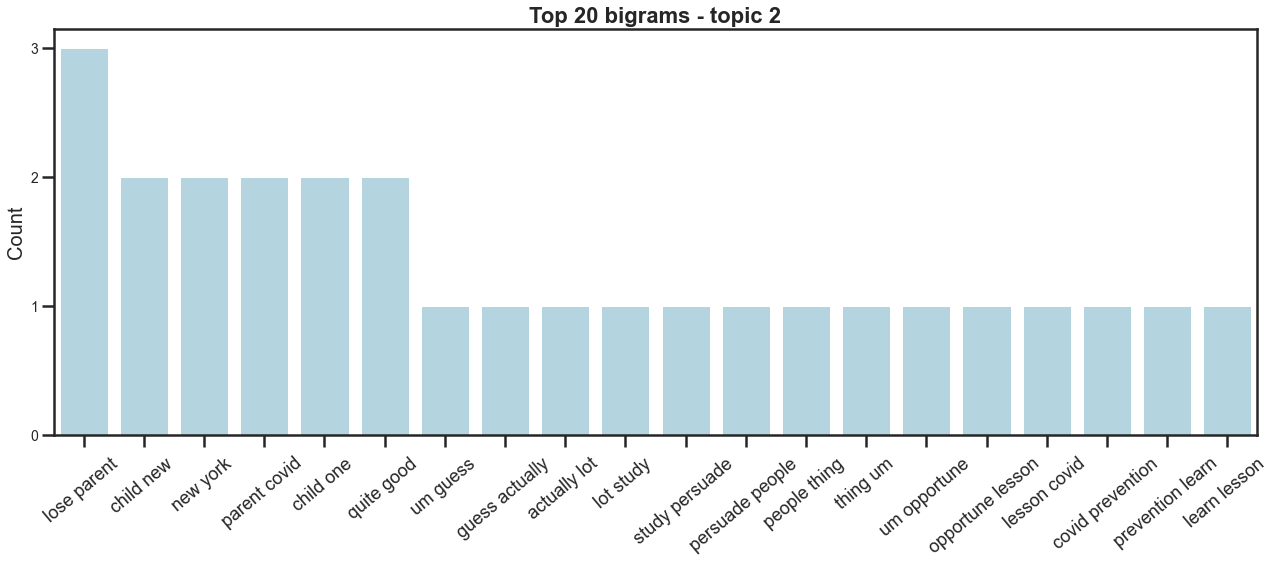

In [354]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_bi = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams - topic 2',
       'fname': graph1+'_topic2_bigrams.png',
       'angle': 40}
plot_frequency_chart(info)

In [355]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')
unigrams = Counter(words).most_common(20)
unigrams


[('um', 9),
 ('covid', 9),
 ('child', 7),
 ('one', 6),
 ('parent', 4),
 ('really', 3),
 ('quite', 3),
 ('lose', 3),
 ('worth', 3),
 ('article', 3),
 ('actually', 2),
 ('people', 2),
 ('lesson', 2),
 ('heartbreaking', 2),
 ('new', 2),
 ('york', 2),
 ('hit', 2),
 ('fairly', 2),
 ('school', 2),
 ('also', 2)]

In [245]:
import random
tokens_topic = []

for doc in tokenizer.pipe(top_tri['Grams'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         if token.text.lower() not in STOP_WORDS:
        doc_tokens.append(token.text.lower())   
    tokens_topic.append(doc_tokens)
tokens_topic
tokens_topic_list=[]
for t in tokens_topic:
    if t[0] not in tokens_topic_list:
        tokens_topic_list.append(t[0])
    if t[1] not in tokens_topic_list:
        tokens_topic_list.append(t[1])
    if t[2] not in tokens_topic_list:
        tokens_topic_list.append(t[2])    
tokens_topic_list


tokens_list= '|'.join(tokens_topic_list)

tokens_list
contain_values = df_filter[df_filter['tokens_back_to_text'].str.contains(tokens_list)]
contain_values_list = contain_values['text'].tolist() 
len(contain_values_list)
random.seed(123)
# contain_values_sample=random.sample(contain_values,10)
for i in contain_values_list:
    print(i)
    print('--------------------------------------------------')

So it's going to be pretty, pretty, mostly clinical and epidemiological.
--------------------------------------------------
And they were pretty balanced regarding gender and ethnicity.
--------------------------------------------------
I think the only the only area that is still somewhat debatable on hydroxychloroquine is we can use it as pre-exposure prophylaxis.
--------------------------------------------------
They were taking these hydroxychloroquine before they they were exposed to COVID.
--------------------------------------------------
But there's definitely no no clinical efficacy in these clinical trial.
--------------------------------------------------
Another, another topic that we have been discussing is the long COVID, and I found this recent paper published in Clinical Microbiology and Infection.
--------------------------------------------------


In [246]:
contain_values

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics,lda_0,lda_1,lda_2,lda_3
0,"So it's going to be pretty, pretty, mostly clinical and epidemiological.",go pretty pretty mostly clinical epidemiological,"[go, pretty, pretty, mostly, clinical, epidemiological]",go pretty pretty mostly clinical epidemiological,"[pretty, pretty, mostly, clinical, epidemiological]",2,0.042139,0.044073,0.872088,0.041701
12,And they were pretty balanced regarding gender and ethnicity.,pretty balanced regard gender ethnicity,"[pretty, balanced, regard, gender, ethnicity]",pretty balanced regard gender ethnicity,"[pretty, balanced, regard, gender, ethnicity]",2,0.083361,0.084679,0.748582,0.083378
36,I think the only the only area that is still somewhat debatable on hydroxychloroquine is we can use it as pre-exposure prophylaxis.,think area still somewhat debatable hydroxychloroquine use pre exposure prophylaxis,"[think, area, still, somewhat, debatable, hydroxychloroquine, use, pre, exposure, prophylaxis]",think area still somewhat debatable hydroxychloroquine use pre exposure prophylaxis,"[area, still, somewhat, debatable, hydroxychloroquine, use, pre, exposure, prophylaxis]",2,0.042776,0.041735,0.873793,0.041695
40,They were taking these hydroxychloroquine before they they were exposed to COVID.,take hydroxychloroquine expose covid,"[take, hydroxychloroquine, expose, covid]",take hydroxychloroquine expose covid,"[take, hydroxychloroquine, expose, covid]",2,0.042131,0.042037,0.874148,0.041684
45,But there's definitely no no clinical efficacy in these clinical trial.,definitely clinical efficacy clinical trial,"[definitely, clinical, efficacy, clinical, trial]",definitely clinical efficacy clinical trial,"[definitely, clinical, efficacy, clinical, trial]",2,0.028799,0.027926,0.915479,0.027796
46,"Another, another topic that we have been discussing is the long COVID, and I found this recent paper published in Clinical Microbiology and Infection.",another another topic discuss long covid find recent paper publish clinical microbiology infection,"[another, another, topic, discuss, long, covid, find, recent, paper, publish, clinical, microbiology, infection]",another another topic discuss long covid find recent paper publish clinical microbiology infection,"[another, another, topic, discuss, long, covid, find, recent, paper, publish, clinical, microbiology, infection]",2,0.019989,0.020170,0.940413,0.019428


## Topic 1

In [247]:
# Topic 2
df_filter = df2.loc[(df2.topics==1) & (df2.lda_1>0.7) ]

# df_filter = topics.loc[topic]

clean_text=df_filter['tokens_back_to_text'].dropna()

big_string= ' '.join([text for text in clean_text])

exceptions_list = [ 'go ', 'actually', 'also'] # pull out these words from the corpus
for word in exceptions_list:
    big_string=big_string.replace(word,'')

big_string=remove_special_characters(big_string, 
                          remove_digits=False)
    
words = big_string.split()
len(words)   

79

['look datum patient ', 1]
['datum patient group ', 1]
['patient group patient ', 1]
['group patient group ', 1]
['patient group early ', 1]
['group early early ', 1]
['early early study ', 1]
['early study group ', 1]
['study group mostly ', 1]
['group mostly mostly ', 1]
['mostly mostly white ', 1]
['mostly white many ', 1]
['white many minority ', 1]
['many minority represent ', 1]
['minority represent study ', 1]
['represent study issue ', 1]
['study issue vaccine ', 1]
['issue vaccine trial ', 1]
['vaccine trial janick ', 1]
['trial janick across ', 1]


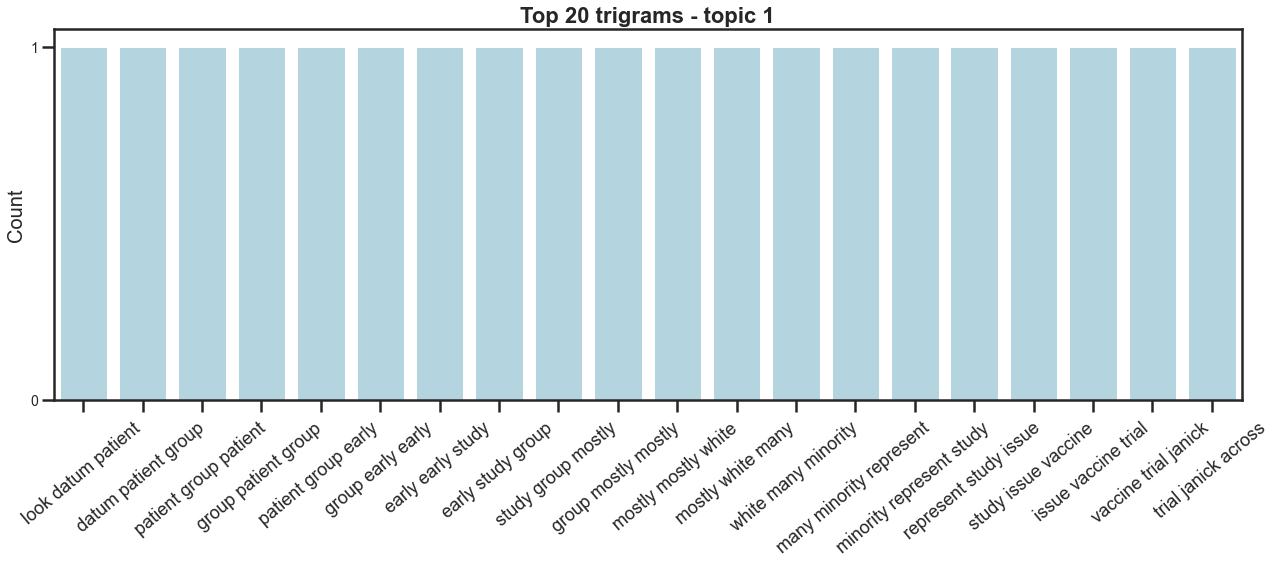

In [248]:
trigrams = nltk.trigrams(words)
df_trigrams = get_trigrams(trigrams, 10)
top_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 trigrams - topic 1',
       'fname':graph1+'_topic1_tigrams.png',
       'angle': 40}
plot_frequency_chart(info)

['patient group ', 2]
['look datum ', 1]
['datum patient ', 1]
['group patient ', 1]
['group early ', 1]
['early early ', 1]
['early study ', 1]
['study group ', 1]
['group mostly ', 1]
['mostly mostly ', 1]
['mostly white ', 1]
['white many ', 1]
['many minority ', 1]
['minority represent ', 1]
['represent study ', 1]
['study issue ', 1]
['issue vaccine ', 1]
['vaccine trial ', 1]
['trial janick ', 1]
['janick across ', 1]


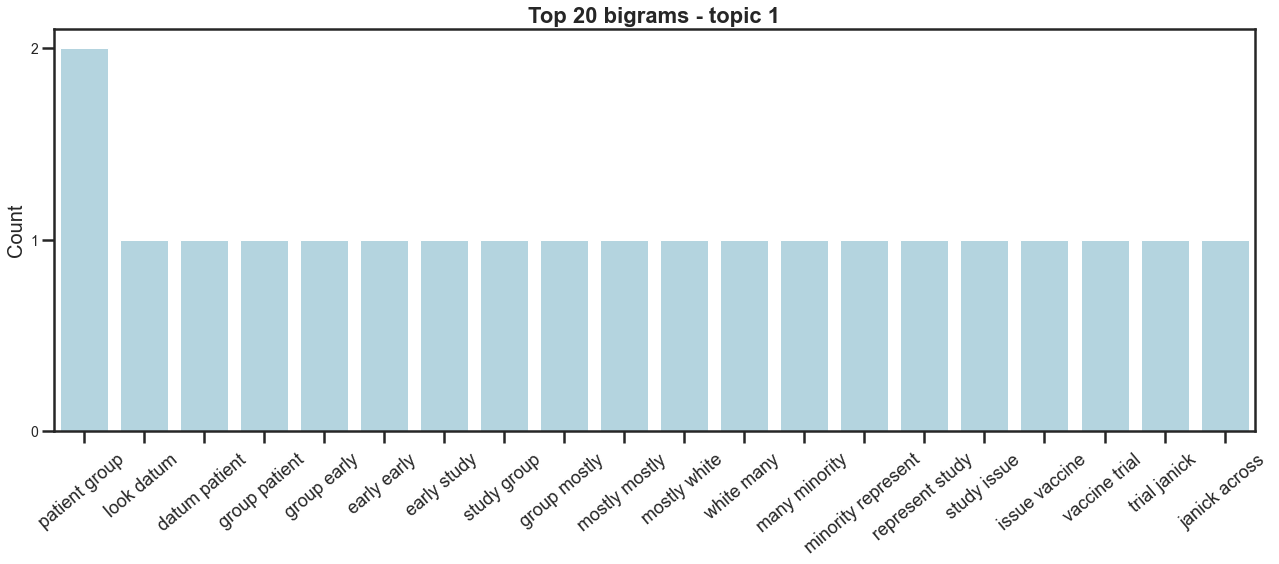

In [249]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_bi = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams - topic 1',
       'fname': graph1+'_topic1_bigrams.png',
       'angle': 40}
plot_frequency_chart(info)

In [250]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')
unigrams = Counter(words).most_common(20)
unigrams


[('group', 5),
 ('patient', 4),
 ('early', 3),
 ('study', 2),
 ('mostly', 2),
 ('trial', 2),
 ('still', 2),
 ('anosmia', 2),
 ('know', 2),
 ('impact', 2),
 ('receive', 2),
 ('oxygen', 2),
 ('benefit', 2),
 ('look', 1),
 ('datum', 1),
 ('white', 1),
 ('many', 1),
 ('minority', 1),
 ('represent', 1),
 ('issue', 1)]

In [251]:
import random
tokens_topic = []

for doc in tokenizer.pipe(top_tri['Grams'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         if token.text.lower() not in STOP_WORDS:
        doc_tokens.append(token.text.lower())   
    tokens_topic.append(doc_tokens)
tokens_topic
tokens_topic_list=[]
for t in tokens_topic:
    if t[0] not in tokens_topic_list:
        tokens_topic_list.append(t[0])
    if t[1] not in tokens_topic_list:
        tokens_topic_list.append(t[1])
    if t[2] not in tokens_topic_list:
        tokens_topic_list.append(t[2])    
tokens_topic_list


tokens_list= '|'.join(tokens_topic_list)

tokens_list
contain_values = df_filter[df_filter['tokens_back_to_text'].str.contains(tokens_list)]
contain_values_list = contain_values['text'].tolist() 
len(contain_values_list)
random.seed(123)
# contain_values_sample=random.sample(contain_values,10)
for i in contain_values_list:
    print(i)
    print('--------------------------------------------------')

They actually look at the data for patients 56 and 70 and also over 71.
--------------------------------------------------
10 in each group, 10 patients in each group.
--------------------------------------------------
This is an early early study, 20 in that group of 56 to 70 and 20 in the more than than 71.
--------------------------------------------------
But mostly, mostly, were actually whites are not too many minorities represented in this study, which is an issue with some of these vaccine trials.
--------------------------------------------------
But there's still some some investigator, which think that if you use it early enough, you may have an effect.
--------------------------------------------------
The anosmia and ageusia we have at the onset 59% hearted on day 30 28 they 60 still, like one quarter of the patient, have these these anosmia, or loss of taste.
--------------------------------------------------
And again, patients with that were receiving oxygen, but not in

In [252]:
contain_values

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics,lda_0,lda_1,lda_2,lda_3
4,They actually look at the data for patients 56 and 70 and also over 71.,actually look datum patient also,"[actually, look, datum, patient, also]",actually look datum patient also,"[look, datum, patient]",1,0.065979,0.799319,0.071867,0.062835
10,"10 in each group, 10 patients in each group.",group patient group,"[group, patient, group]",group patient group,"[group, patient, group]",1,0.065475,0.807023,0.064721,0.062781
11,"This is an early early study, 20 in that group of 56 to 70 and 20 in the more than than 71.",early early study group,"[early, early, study, group]",early early study group,"[early, early, study, group]",1,0.051015,0.848605,0.050361,0.050019
13,"But mostly, mostly, were actually whites are not too many minorities represented in this study, which is an issue with some of these vaccine trials.",mostly mostly actually white many minority represent study issue vaccine trial,"[mostly, mostly, actually, white, many, minority, represent, study, issue, vaccine, trial]",mostly mostly actually white many minority represent study issue vaccine trial,"[mostly, mostly, white, many, minority, represent, study, issue, vaccine, trial]",1,0.041374,0.886048,0.036841,0.035736
38,"But there's still some some investigator, which think that if you use it early enough, you may have an effect.",still investigator think use early enough may effect,"[still, investigator, think, use, early, enough, may, effect]",still investigator think use early enough may effect,"[still, investigator, use, early, enough, may, effect]",1,0.068808,0.800033,0.068614,0.062546
59,"The anosmia and ageusia we have at the onset 59% hearted on day 30 28 they 60 still, like one quarter of the patient, have these these anosmia, or loss of taste.",anosmia ageusia onset hearte day still like one quarter patient anosmia loss taste,"[anosmia, ageusia, onset, hearte, day, still, like, one, quarter, patient, anosmia, loss, taste]",anosmia ageusia onset hearte day still like one quarter patient anosmia loss taste,"[anosmia, ageusia, onset, hearte, day, still, quarter, patient, anosmia, loss, taste]",1,0.052110,0.839098,0.058166,0.050626
84,"And again, patients with that were receiving oxygen, but not in ECMO or mechanical ventilation, where those who benefit the most was the larger group and was also the group that received more bene...",patient receive oxygen ecmo mechanical ventilation benefit large group also group receive benefit beginning disease require oxygen significant change,"[patient, receive, oxygen, ecmo, mechanical, ventilation, benefit, large, group, also, group, receive, benefit, beginning, disease, require, oxygen, significant, change]",patient receive oxygen ecmo mechanical ventilation benefit large group also group receive benefit beginning disease require oxygen significant change,"[patient, receive, oxygen, ecmo, mechanical, ventilation, benefit, large, group, group, receive, benefit, beginning, disease, require, oxygen, significant, change]",1,0.063512,0.807136,0.065132,0.064220


## Topic 3

In [262]:
# Topic 3
df_filter = df2.loc[(df2.topics==3) & (df2.lda_3>0.7) ]

# df_filter = topics.loc[topic]

clean_text=df_filter['tokens_back_to_text'].dropna()

big_string= ' '.join([text for text in clean_text])

exceptions_list = [ 'go ', 'something', 'used', 'see', 'actually'] # pull out these words from the corpus
for word in exceptions_list:
    big_string=big_string.replace(word,'')

big_string=remove_special_characters(big_string, 
                          remove_digits=False)
    
words = big_string.split()
len(words)   

40

['basically protocol adverse ', 1]
['protocol adverse event ', 1]
['adverse event use ', 1]
['event use first ', 1]
['use first vaccination ', 1]
['first vaccination column ', 1]
['vaccination column left ', 1]
['column left produce ', 1]
['left produce much ', 1]
['produce much way ', 1]
['much way adverse ', 1]
['way adverse event ', 1]
['adverse event get ', 1]
['event get low ', 1]
['get low grade ', 1]
['low grade fever ', 1]
['grade fever fatigue ', 1]
['fever fatigue soreness ', 1]
['fatigue soreness area ', 1]
['soreness area injection ', 1]


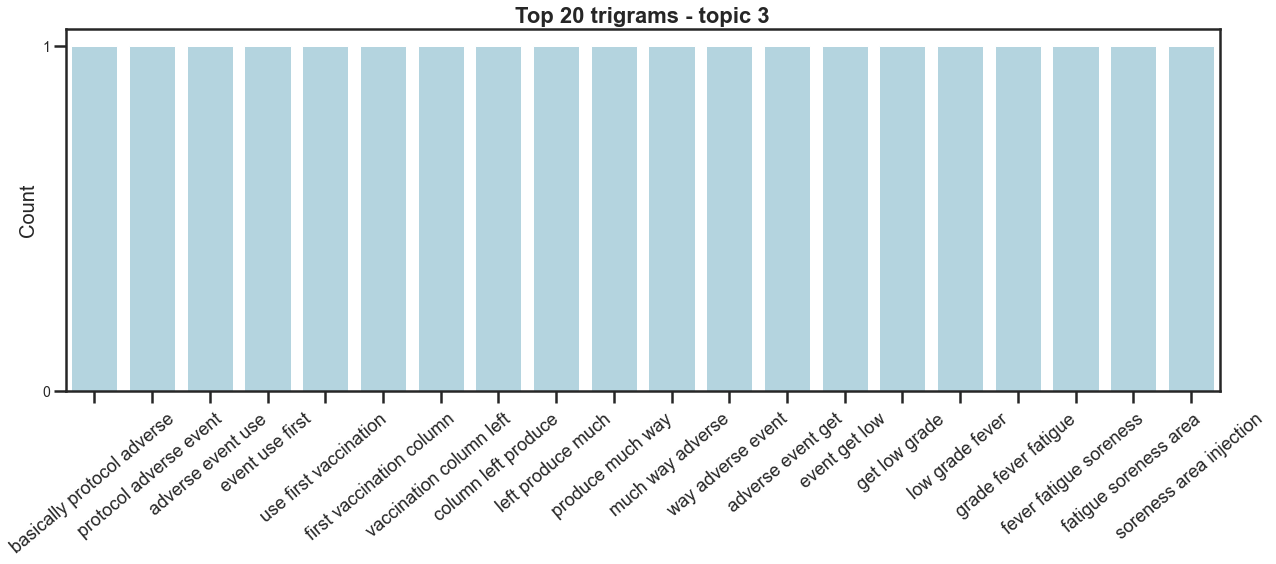

In [263]:
trigrams = nltk.trigrams(words)
df_trigrams = get_trigrams(trigrams, 10)
top_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 trigrams - topic 3',
       'fname':graph1+'_topic3_tigrams.png',
       'angle': 40}
plot_frequency_chart(info)

['adverse event ', 2]
['immune response ', 2]
['basically protocol ', 1]
['protocol adverse ', 1]
['event use ', 1]
['use first ', 1]
['first vaccination ', 1]
['vaccination column ', 1]
['column left ', 1]
['left produce ', 1]
['produce much ', 1]
['much way ', 1]
['way adverse ', 1]
['event get ', 1]
['get low ', 1]
['low grade ', 1]
['grade fever ', 1]
['fever fatigue ', 1]
['fatigue soreness ', 1]
['soreness area ', 1]


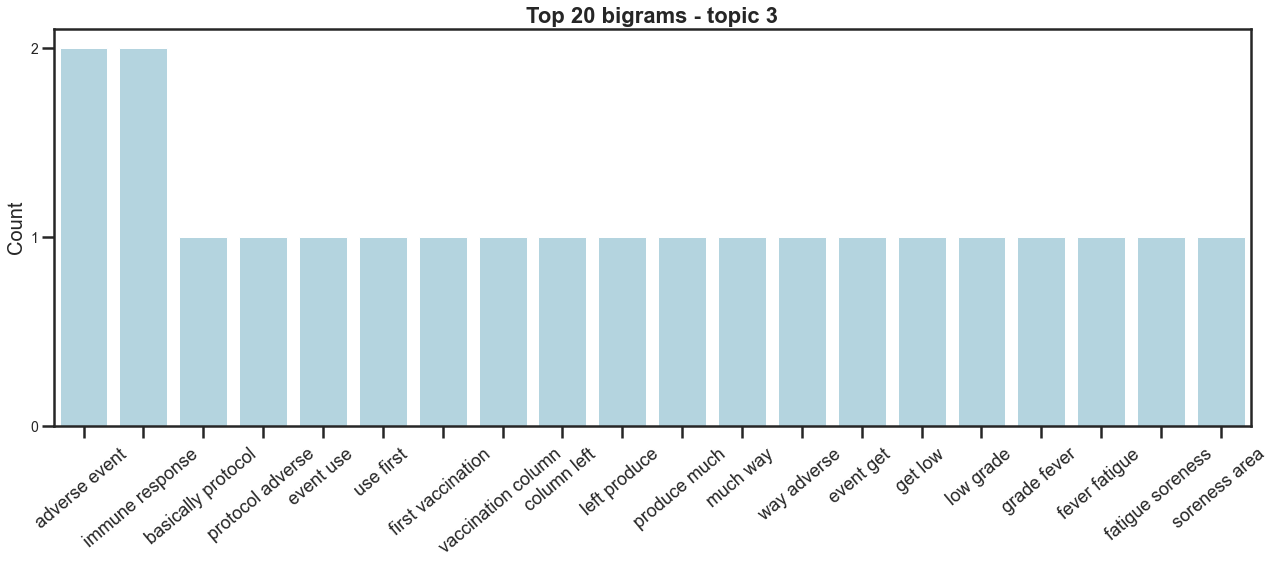

In [264]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_bi = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams - topic 3',
       'fname': graph1+'_topic3_bigrams.png',
       'angle': 40}
plot_frequency_chart(info)

In [265]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')
unigrams = Counter(words).most_common(20)
unigrams


[('response', 3),
 ('adverse', 2),
 ('event', 2),
 ('immune', 2),
 ('basically', 1),
 ('protocol', 1),
 ('use', 1),
 ('first', 1),
 ('vaccination', 1),
 ('column', 1),
 ('left', 1),
 ('produce', 1),
 ('much', 1),
 ('way', 1),
 ('get', 1),
 ('low', 1),
 ('grade', 1),
 ('fever', 1),
 ('fatigue', 1),
 ('soreness', 1)]

In [266]:
import random
tokens_topic = []

for doc in tokenizer.pipe(top_tri['Grams'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         if token.text.lower() not in STOP_WORDS:
        doc_tokens.append(token.text.lower())   
    tokens_topic.append(doc_tokens)
tokens_topic
tokens_topic_list=[]
for t in tokens_topic:
    if t[0] not in tokens_topic_list:
        tokens_topic_list.append(t[0])
    if t[1] not in tokens_topic_list:
        tokens_topic_list.append(t[1])
    if t[2] not in tokens_topic_list:
        tokens_topic_list.append(t[2])    
tokens_topic_list


tokens_list= '|'.join(tokens_topic_list)

tokens_list
contain_values = df_filter[df_filter['tokens_back_to_text'].str.contains(tokens_list)]
contain_values_list = contain_values['text'].tolist() 
len(contain_values_list)
random.seed(123)
# contain_values_sample=random.sample(contain_values,10)
for i in contain_values_list:
    print(i)
    print('--------------------------------------------------')

This is the basically the protocol.
--------------------------------------------------
The adverse event.
--------------------------------------------------
It's something that we're used to see.
--------------------------------------------------
The first vaccination, which is the column on the left, doesn't produce that much in the way of adverse events.
--------------------------------------------------


In [267]:
contain_values

,text,text_clean,tokens,tokens_back_to_text,tokens2,topics,lda_0,lda_1,lda_2,lda_3
8,This is the basically the protocol.,basically protocol,"[basically, protocol]",basically protocol,"[basically, protocol]",3,0.083703,0.083364,0.083358,0.749575
14,The adverse event.,adverse event,"[adverse, event]",adverse event,"[adverse, event]",3,0.083357,0.083367,0.083361,0.749914
15,It's something that we're used to see.,something use see,"[something, use, see]",something use see,"[something, use]",3,0.083679,0.084257,0.083587,0.748477
16,"The first vaccination, which is the column on the left, doesn't produce that much in the way of adverse events.",first vaccination column left produce much way adverse event,"[first, vaccination, column, left, produce, much, way, adverse, event]",first vaccination column left produce much way adverse event,"[first, vaccination, column, left, produce, way, adverse, event]",3,0.035829,0.035733,0.036763,0.891675
